In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from dython.nominal import associations
%matplotlib inline

from sklearn import metrics
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.base import clone 
from boruta import BorutaPy
from sklearn.neural_network import MLPClassifier

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC

from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import KFold


from scipy.stats import pointbiserialr
import scipy.stats as stats
import scipy.stats as ss
from scipy.stats.mstats import winsorize

import optuna
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, space_eval

import warnings
warnings.filterwarnings("ignore")

## Supervised Learning Capstone: Predicting Unauthorized Status Among Noncitizens Using Census Data

My purpose for this capstone is to build a model using U.S. Census survey data that predicts a noncitizen's legal status reasonably well. I am a political scientist working in the health care policy research and advocacy space and much of my work would benefit from having the ability to filter out this population from measures of eligibility for health insurance programs in the United States. Estimating the unauthorized immigrant population is an important step in the process of calculating how many residents in the United States fall into the so-called health insurance "coverage gap." People who fall into this category are those who make too much money to qualify for Medicaid but do not make enough to qualify for government subsidized health insurance premiums on the health insurance exchanges. I am currently working on a project centered on the coverage gap and I would like to be able to measure the unauthorized population in Florida's major metropolitan areas. 

I will use data from the 2008 Survey of Income and Program Participation (SIPP), which is a national panel survey of approximately 390,000 individuals in 50,000-60,000 households over a four-year period. The U.S. government uses it to track microeconomic trends and analyze how government programs affect American households over time. The panel is asked a core set of questions in every wave that measures socioeconomic status, demographics, and receipt of and use of government spending program transfers. Each wave also includes an additional set of questions on a specific topic. The second wave covers ethnicity and immigration and it will form the basis of my analysis here. I will also incorporate functional limitations measures from the fourth wave because influential studies of unauthorized immigrants have used it to classify noncitizens. 

Researchers who use the 2008 SIPP to estimate unauthorized status among noncitizens typically merge the second wave data with a larger Census dataset, either the American Community Survey (ACS) or Current Population Survey (CPS), and use a multiple imputation algorithm algorithm to predict a noncitizen's legal status. The ACS and CPS measure respondents' citizenship status, but do not probe further to measure whether they are in the United States legally. The SIPP, on other hand, includes questions measuring whether the person came to the U.S. as a legal permanent resident (LPR) or whether they have "adjusted" to permanent status since entering the country. It also measures other forms of legal entry through various visa programs or whether the person is a refugee or asylee, but the government only provides data on LPR status. Researchers must apply for special access to the other legal status measures and pay a hefty access fee (I will rely on the public data instead). 

All of the Census surveys ask the same set of ethnicity, demographic, and socioeconomic status questions, so researchers may combine the SIPP and ACS (or CPS) for a multiple imputation analysis. The algorithms thus "impute" legal status in the data from the ACS or CPS in the pooled data file.
    
Pivoting from the literature, I will use machine learning algorithms to train a model to predict unauthorized status in the SIPP with the hopes of accurately predicting a noncitizen's legal status. If I am successful, I can use the model on either the ACS or CPS to predict unauthorized status in those datasets (which is my plan). 

For each wave, the survey data is housed in three files: the core file, the topical module file, and the file with replicate weights. I will only use the core and the topical module files here. 

In [2]:
# Reading in the topical modules

sipp2008_w2tm = pd.read_stata('/Users/machilders/Documents/Data Science/Thinkful/Data Files/sipp2008/sipp2008w2.dta')
sipp2008_w4tm = pd.read_stata('/Users/machilders/Documents/Research/Data/SIPP/sippp08putm4.dta')

In [3]:
# Reading in the core data

sipp2008_w2core = pd.read_stata('/Users/machilders/Documents/Data Science/Thinkful/Data Files/sipp2008/sipp2008core.dta')

### Background and Potential Features

There are a few groups of social scientists who have estimated the number of unauthorized immigrants in the United States whose models are either widely used, or widely cited in the news and among policymakers. Pew Research Center's methods (PRC) are the most well known and they use a method referred to as the "residual method." It employs a combination of administrative statistics on the number of legal noncitizens from the federal government and Census survey data (ACS) to estimate the unlawful population. Their early attempts in the late 1990s were rather simple: they used Census estimates of the noncitizen population and substracted the government's official number of lawful noncitizens to calculate the number of unauthorized immigrants. 

As computer processing technology advanced, social scientists at PRC and in academia began to use multiple imputation algorithms to create more precise and granular estimates. They pooled SIPP and ACS data to impute a noncitizen's legal status, with the SIPP being the 'donor' data and the ACS being the target. Both surveys sample the national population in similar ways and use a common set of socioeconomic and demographic features to serve as predictors. The SIPP asks its noncitizen respondents whether they had legal status when they entered the country and if they have since become legal permanent residents. The ACS, on the other hand, only asks respondents if they are citizens, without probing them further to infer their legal status. Thus, in the pooled dataset, a variable measuring a noncitizen's legal status would have missing values for noncitizens from the ACS.  

For this analysis, I will use features from three unauthorized immigrant multiple imputation models that are popular in social science research to build a classification model. The first is from a 2014 study testing alternative methods and it uses eight features (see below). The second is a central component in a Kaiser Family Foundation (KFF) analysis estimating the number of low-income Americans who are in the health insurance "coverage gap". The KFF study is considered to be the gold standard for estimating the size of this population. The third is a model used by the Migration Policy Institute for its work measuring how federal policies impact the immigrant population. 

    Van Hook, Jennifer, James D. Bachmeier, Donna L. Coffman, and Ofer Harel. 2015. “Can We Spin Straw Into Gold? An Evaluation of Immigrant Legal Status Imputation Approaches.” Demography 52 (1): 329–54. https://doi.org/10.1007/s13524-014-0358-x.
- Family poverty level 
- education level
- Born in Mexico
- Years of U.S. residence
- age
- gender
- Number of functional limitations (disabilities)
- Poor health

The Van Hook et al. group's feature set has the fewest dimensions, but we are not able to completely replicate it. Looking into the future stages of this project, the ACS does not include measures of Americans' health status. On the other hand, most of the remaining features overlap with the two models below.

    Garfield, Rachel, Kendal Orgera, and Anthony Damico. 2019. “The Coverage Gap: Uninsured Poor Adults in States That Do Not Expand Medicaid.” Issue brief. Washington, D.C.: Kaiser Family Foundation. https://www.kff.org/medicaid/issue-brief/the-coverage-gap-uninsured-poor-adults-in-states-that-do-not-expand-medicaid/.
- Year of US entry,
- Job industry classification,
- State of residence,
- Family Poverty Level,
- Ownership or rental of residence,
- Presence of at least one citizen in household,
- Number of occupants in the household (< or >= six occupants),
- Whether all household occupants are related,
- Number of workers in household,
- Health insurance coverage status,
- Gender
- Ethnicity-Hispanic or Latino Origin

We can replicate this model completely because both the SIPP and ACS have all of the features. 

    Capps, Randy, James D. Bachmeier, Michael Fix, and Jennifer Van Hook. 2013. “A Demographic, Socioeconomic, and Health Coverage Profile of Unauthorized Immigrants in the United States.” 5. Washington D.C.: Migration Policy Institute. https://www.migrationpolicy.org/research/demographic-socioeconomic-and-health-coverage-profile-unauthorized-immigrants-united-states.
- world region of birth 
- duration of US residence 
- English language proficiency
- age
- sex 
- are they married or not
- parental status (has children)
- household size
- educational attainment
- homeownership
- insurance coverage
- labor force status
- income-to-poverty ratio
- US state/region of residence

### Variables to keep from core file:

Identifiers and weights:
'ssuid' , 'shhadid', 'epppnum' , 'rfid' , 'rsid', 'wpfinwgt', 'srefmon',

Demographic:
'tage' ,'ebornus' , 'ecitizen' , 'tftotinc' , 'rfpov' ,
'ejbind1' , 'eorigin' , 'tfipsst', 'epdjbthn' , 'etenure' ,
'esex' , 'tmetro', 'tjbocc1', 'ehowwell', 'eeducate', 'epnspous', 'epnmom', 'epndad', 'errp', 'esftype', 'espeak', 'esfr', 'shhadid', 'eftype', 'rdesgpnt', 'ems', 'eafever', 'efrefper'

Insurance Vars:
'rchampm' , 'er20' , 'er03a' , 'er01a' , 'rprvhi' ,
'rprvhi2' , 'emcocov' , 'ecrmth' , 'ecdmth'

### Variables to keep from topical files: 

Wave 2: 
identifiers:
'ssuid', 'epppnum',

migration variables:
'timstat', 'eadjust','tmoveus', 'tbrstate', 'tmovyryr', 'bcntry'

Wave 4:
identifiers:
'ssuid', 'epppnum',

functional limitation variables (standard federal functional limitation questions, also in ACS and CPS):
'edis' 1-6

In [4]:
# Creating smaller dataset with variables from core file

sipp2008_w2core_small = sipp2008_w2core[['ssuid' , 'shhadid', 'epppnum' , 'rfid' , 'rfid2', 'rsid','wpfinwgt', 'tage', 'ebornus',
                                         'ecitizen', 'tftotinc', 'rfpov', 'ejbind1', 'epdjbthn', 'tjbocc1', 'erace',
                                         'eorigin', 'tfipsst', 'etenure','esex', 'tmetro', 'rdesgpnt',
                                         'rchampm', 'er20', 'er03a', 'er01a', 'rprvhi', 'rprvhi2','emcocov', 
                                         'ecrmth', 'ecdmth','srefmon', 'eeducate', 'espeak', 'ehowwell', 'epnspous', 
                                         'epnmom', 'epndad', 'errp', 'esftype', 'esfr', 'eftype', 'eafever',
                                         'efkind', 'efspouse', 'ehiowner', 'ems', 'efrefper']]


In [5]:
# Checking to see if the data looks OK

sipp2008_w2core_small.head()

,ssuid,shhadid,epppnum,rfid,rfid2,rsid,wpfinwgt,tage,ebornus,ecitizen,...,errp,esftype,esfr,eftype,eafever,efkind,efspouse,ehiowner,ems,efrefper
0,019128000276,11,0101,1,1,-1,3903.1606,29,2,2,...,1,-1,0,1,2,1,102,1,1,101
1,019128000276,11,0101,2,2,-1,3979.0720,29,2,2,...,1,-1,0,1,2,1,102,1,1,101
2,019128000276,11,0101,3,3,-1,4056.2319,29,2,2,...,1,-1,0,1,2,1,102,1,1,101
3,019128000276,11,0101,4,4,-1,3973.9954,29,2,2,...,1,-1,0,1,2,1,102,1,1,101
4,019128000276,11,0102,1,1,-1,3903.1606,32,2,2,...,3,-1,0,1,2,1,102,2,1,101


In [6]:
# Creating smaller topical module files with migration variables-Wave 2

sipp2008_w2tm_small = sipp2008_w2tm[['ssuid', 'epppnum', 'timstat', 'eadjust','tmoveus', 'tbrstate', 'tmovyryr']]

In [7]:
# Creating smaller topical module from wave 4
sipp2008_w4tm_small = sipp2008_w4tm[['ssuid', 'epppnum', 'edis1', 'edis2', 'edis3', 'edis4', 'edis5', 'edis6']]

In [8]:
# Checking the data types in the core file.

sipp2008_w2core_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392702 entries, 0 to 392701
Data columns (total 48 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ssuid     392702 non-null  object 
 1   shhadid   392702 non-null  int16  
 2   epppnum   392702 non-null  object 
 3   rfid      392702 non-null  int16  
 4   rfid2     392702 non-null  int16  
 5   rsid      392702 non-null  int16  
 6   wpfinwgt  392702 non-null  float64
 7   tage      392702 non-null  int8   
 8   ebornus   392702 non-null  int8   
 9   ecitizen  392702 non-null  int8   
 10  tftotinc  392702 non-null  int32  
 11  rfpov     392702 non-null  int32  
 12  ejbind1   392702 non-null  int16  
 13  epdjbthn  392702 non-null  int8   
 14  tjbocc1   392702 non-null  int16  
 15  erace     392702 non-null  int8   
 16  eorigin   392702 non-null  int8   
 17  tfipsst   392702 non-null  int8   
 18  etenure   392702 non-null  int8   
 19  esex      392702 non-null  int8   
 20  tmet

### Creating identifier variable for respondents

Every person is assigned a household number and a person number within that household. We can combine them to create an ID variable. The household and person number variables are strings, so we can add them together and convert to a numeric column later. We will do this for each of the three files that we have read into Pandas before we combine them into one for the analysis. 

In [9]:
# Unique identifiers for respondents can be created by concatenating ssuid (household number) and 
# epppnum (person number)
# These two columns are objects, but we will convert them to numeric while combining them. 
    
sipp2008_w2core_small['pid'] = pd.to_numeric(sipp2008_w2core_small['ssuid'].str.cat(sipp2008_w2core_small['epppnum']))

### Creating a household identifier and a family identifier

We can create a houshold identifier by cancatenating "ssuid" and "sshadid" and a family identifier by concatenating "ssuid", "sshadid", and "rfid."

In [10]:
sipp2008_w2core_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392702 entries, 0 to 392701
Data columns (total 49 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ssuid     392702 non-null  object 
 1   shhadid   392702 non-null  int16  
 2   epppnum   392702 non-null  object 
 3   rfid      392702 non-null  int16  
 4   rfid2     392702 non-null  int16  
 5   rsid      392702 non-null  int16  
 6   wpfinwgt  392702 non-null  float64
 7   tage      392702 non-null  int8   
 8   ebornus   392702 non-null  int8   
 9   ecitizen  392702 non-null  int8   
 10  tftotinc  392702 non-null  int32  
 11  rfpov     392702 non-null  int32  
 12  ejbind1   392702 non-null  int16  
 13  epdjbthn  392702 non-null  int8   
 14  tjbocc1   392702 non-null  int16  
 15  erace     392702 non-null  int8   
 16  eorigin   392702 non-null  int8   
 17  tfipsst   392702 non-null  int8   
 18  etenure   392702 non-null  int8   
 19  esex      392702 non-null  int8   
 20  tmet

In [11]:
# Let's convert 'shhadid' into a string column to concatenate it with ssuid to 
# create the household id column.

sipp2008_w2core_small['shhadid'] = sipp2008_w2core_small['shhadid'].astype(str)

sipp2008_w2core_small['hhid'] = sipp2008_w2core_small['ssuid'] + sipp2008_w2core_small['shhadid']

In [12]:
# Looks like it worked OK

sipp2008_w2core_small[['ssuid', 'shhadid', 'hhid']].head(10)

,ssuid,shhadid,hhid
0,019128000276,11,01912800027611
1,019128000276,11,01912800027611
2,019128000276,11,01912800027611
3,019128000276,11,01912800027611
4,019128000276,11,01912800027611
5,019128000276,11,01912800027611
6,019128000276,11,01912800027611
7,019128000276,11,01912800027611
8,019128000276,11,01912800027611
9,019128000276,11,01912800027611


In [13]:
 # Create a family identifier with ssuid + shhadid + rfid

sipp2008_w2core_small['family'] = sipp2008_w2core_small['ssuid'] + sipp2008_w2core_small['shhadid'] + sipp2008_w2core_small['rfid'].astype(str)

In [14]:
sipp2008_w2core_small[['pid', 'hhid', 'family', 'ssuid', 'shhadid', 'rfid']].head(10)

,pid,hhid,family,ssuid,shhadid,rfid
0,191280002760101,01912800027611,019128000276111,019128000276,11,1
1,191280002760101,01912800027611,019128000276112,019128000276,11,2
2,191280002760101,01912800027611,019128000276113,019128000276,11,3
3,191280002760101,01912800027611,019128000276114,019128000276,11,4
4,191280002760102,01912800027611,019128000276111,019128000276,11,1
5,191280002760102,01912800027611,019128000276112,019128000276,11,2
6,191280002760102,01912800027611,019128000276113,019128000276,11,3
7,191280002760102,01912800027611,019128000276114,019128000276,11,4
8,191280002760103,01912800027611,019128000276111,019128000276,11,1
9,191280002760103,01912800027611,019128000276112,019128000276,11,2


In [15]:
# Creating a pid variable in Wave 2 topical module (reduced file)

sipp2008_w2tm_small['pid'] = pd.to_numeric(sipp2008_w2tm_small['ssuid'] + sipp2008_w2tm_small['epppnum'])

In [16]:
sipp2008_w2tm_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98504 entries, 0 to 98503
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ssuid     98504 non-null  object
 1   epppnum   98504 non-null  object
 2   timstat   98504 non-null  int8  
 3   eadjust   98504 non-null  int8  
 4   tmoveus   98504 non-null  int16 
 5   tbrstate  98504 non-null  int16 
 6   tmovyryr  98504 non-null  int16 
 7   pid       98504 non-null  int64 
dtypes: int16(3), int64(1), int8(2), object(2)
memory usage: 3.8+ MB


In [17]:
# Creating a pid variable in Wave 4 topical module file

sipp2008_w4tm_small['pid'] = pd.to_numeric(sipp2008_w4tm_small['ssuid'].str.cat(sipp2008_w4tm_small['epppnum']))

We are going to drop all observations in reference months 1-3 in the core file in order to allow us to merge it with the topical module file. The topical module file only contains data from the fourth reference month.

In [18]:
sipp2008_w2core_small = sipp2008_w2core_small[sipp2008_w2core_small.srefmon == 4].reset_index()

In [19]:
sipp2008_w2core_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98504 entries, 0 to 98503
Data columns (total 52 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     98504 non-null  int64  
 1   ssuid     98504 non-null  object 
 2   shhadid   98504 non-null  object 
 3   epppnum   98504 non-null  object 
 4   rfid      98504 non-null  int16  
 5   rfid2     98504 non-null  int16  
 6   rsid      98504 non-null  int16  
 7   wpfinwgt  98504 non-null  float64
 8   tage      98504 non-null  int8   
 9   ebornus   98504 non-null  int8   
 10  ecitizen  98504 non-null  int8   
 11  tftotinc  98504 non-null  int32  
 12  rfpov     98504 non-null  int32  
 13  ejbind1   98504 non-null  int16  
 14  epdjbthn  98504 non-null  int8   
 15  tjbocc1   98504 non-null  int16  
 16  erace     98504 non-null  int8   
 17  eorigin   98504 non-null  int8   
 18  tfipsst   98504 non-null  int8   
 19  etenure   98504 non-null  int8   
 20  esex      98504 non-null  in

In [20]:
# Merging core and 2nd wave topical module file 

sipp2008w2_all = pd.merge(sipp2008_w2core_small, sipp2008_w2tm_small[['timstat', 'eadjust', 'tmoveus', 'tbrstate', 'tmovyryr', 'pid']], how = 'left', on = 'pid')

In [21]:
# Merging in the 4th wave tm file

sipp2008w2_all = pd.merge(sipp2008w2_all, sipp2008_w4tm_small[['edis1', 'edis2', 'edis3', 'edis4', 'edis5', 'edis6', 'pid']], how = 'left', on = 'pid')

In [22]:
sipp2008w2_all.head()

,index,ssuid,shhadid,epppnum,rfid,rfid2,rsid,wpfinwgt,tage,ebornus,...,eadjust,tmoveus,tbrstate,tmovyryr,edis1,edis2,edis3,edis4,edis5,edis6
0,3,019128000276,11,0101,4,4,-1,3973.9954,29,2,...,2,16,567,2004,No,No,No,No,No,No
1,7,019128000276,11,0102,4,4,-1,3973.9954,32,2,...,2,16,567,2004,No,No,No,No,No,No
2,11,019128000276,11,0103,4,4,-1,4638.2197,7,2,...,-1,-1,-1,-1,Not in Universe,Not in Universe,Not in Universe,Not in Universe,Not in Universe,Not in Universe
3,18,019128000334,11,0102,4,4,-1,4200.6714,23,1,...,-1,-1,48,2008,No,No,No,No,No,No
4,22,019128000932,11,0101,4,4,-1,3107.6404,51,2,...,-1,15,568,2004,No,No,No,No,No,No


### Feature Engineering and Data Wranging

Now that the files are merged together, let's begin wrangling the data to use in machine learning algorithms. 

### KFF Features

- Year of US entry,
- Job industry classification,
- State of residence,
- Family Poverty Level,
- Ownership or rental of residence,
- Presence of at least one citizen in household,
- Number of occupants in the household (< or >= six occupants),
- Whether all household occupants are related,
- Number of workers in household,
- Health insurance coverage status,
- Gender
- Ethnicity

#### State of Residence
The six states with the highest immigrant populations are:
- 6: California
- 12: Florida
- 17: Illinois
- 34: New Jersey
- 36: New York
- 48: Texas
- Rest of the United States

In [23]:
# State of Residence

# United States
sipp2008w2_all.loc[sipp2008w2_all['tfipsst'].notnull(), 'noncitizen_state'] = 0

# California
sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 6, 'noncitizen_state'] = 6

# Florida
sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 12, 'noncitizen_state'] = 12

# Illinois

sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 17,'noncitizen_state'] = 17

# New Jersey

sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 34, 'noncitizen_state'] = 34

# New York

sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 36, 'noncitizen_state'] = 36

# Texas

sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 48, 'noncitizen_state'] = 48

In [24]:
pd.crosstab(sipp2008w2_all['tfipsst'],sipp2008w2_all['noncitizen_state'])

noncitizen_state,0.0,6.0,12.0,17.0,34.0,36.0,48.0
tfipsst,,,,,,,
1,1363,0,0,0,0,0,0
2,233,0,0,0,0,0,0
4,2681,0,0,0,0,0,0
5,946,0,0,0,0,0,0
6,0,9862,0,0,0,0,0
8,1317,0,0,0,0,0,0
9,988,0,0,0,0,0,0
10,284,0,0,0,0,0,0
11,199,0,0,0,0,0,0


####  Household size

In [25]:
# Counting Number of People in Household

sipp2008w2_all['num_hh'] = sipp2008w2_all.groupby('hhid')['hhid'].transform("count")

#### Family Size

In [26]:
# Counting number of people in family

sipp2008w2_all['family_size'] = sipp2008w2_all.groupby(['hhid', 'family'])['family'].transform("count")

#### Is everyone in the household related?

In [27]:
# Dummy measuring whether everyone in HH is related or not

sipp2008w2_all['hh_related'] = np.where(sipp2008w2_all['num_hh'] == sipp2008w2_all['family_size'], 1, 0)

#### Measuring Employment

In [28]:
# Creating a column equaling 1 if person has a job, 0 if not

sipp2008w2_all.loc[sipp2008w2_all['epdjbthn'] == 1, 'has_job'] = 1
sipp2008w2_all.loc[sipp2008w2_all['epdjbthn'] == 2, 'has_job'] = 0
sipp2008w2_all.loc[sipp2008w2_all['epdjbthn'] == -1, 'has_job'] = np.nan

# Creating column with number of workers in HH

sipp2008w2_all['hh_workers'] = sipp2008w2_all.groupby('hhid')['has_job'].transform('sum')

# Replacing missing values on "has_job" with -1

sipp2008w2_all.loc[sipp2008w2_all['epdjbthn'] == -1, 'has_job'] = -1

In [29]:
# Creating a job variable with a helper function, has categories

def job(x):
    
    # Has no job
    if x['epdjbthn'] == 2:
        return 0
    
    # Not in universe
    elif x['epdjbthn'] == -1:
        return -1
    
    # Works in all other industries
    elif x['epdjbthn'] == 1:
        return 4
    
    # Works in construction
    elif x['ejbind1'] == 770 and x['epdjbthn'] == 1:
        return 1
    
    # Works in wholesale
    elif (x['ejbind1'] >= 4070 and x['ejbind1'] <= 4590) and x['epdjbthn'] == 1:
        return 2
    
    # Works in professional services
    elif (x['ejbind1'] >= 7270 and x['ejbind1'] <= 7490) and x['epdjbthn'] == 1:
        return 3
    
sipp2008w2_all['job'] = sipp2008w2_all.apply(job, axis=1)

In [30]:
job_labels = {0: 'Unemployed', 1: 'Construction', 2: 'Wholesale', 3: 'Professional services',
              4: 'Other industries'}

sipp2008w2_all['job_labels'] = sipp2008w2_all['job'].map(job_labels)

#### Health Insurance Coverage

In [31]:
# Creating an insurance summary variable

# Uninsured
sipp2008w2_all.loc[(sipp2008w2_all['ehiowner'] == 4), 'insurance'] = 1

# 'Other'

sipp2008w2_all.loc[(sipp2008w2_all['rprvhi'] == 4) |
                   (sipp2008w2_all['rprvhi'] == 4), 'insurance'] = 2

# Privately-purchased insurance
sipp2008w2_all.loc[(sipp2008w2_all['rprvhi'] == 2) | 
                  (sipp2008w2_all['rprvhi2'] == 2), 'insurance'] = 3

# Employer-sponsored insurance | Union insurance
sipp2008w2_all.loc[(sipp2008w2_all['rprvhi'] == 1) |
                   (sipp2008w2_all['rprvhi2'] ==1), 'insurance'] = 4

# Military insurance (including veterans insurance)

sipp2008w2_all.loc[(sipp2008w2_all['rprvhi'] == 3) | 
                   (sipp2008w2_all['rprvhi2'] == 3) |
                   (sipp2008w2_all['rchampm'] ==  1), 'insurance'] = 5
                    

# Medicaid/CHIP/Medicare
sipp2008w2_all.loc[(sipp2008w2_all['ecrmth'] == 1) | 
                   (sipp2008w2_all['ecdmth'] == 1) |
                   ((sipp2008w2_all['emcocov'] >= 1) & 
                   (sipp2008w2_all['emcocov'] <= 3)), 'insurance'] = 6


In [32]:
# Creating insurance labels column

insurance_labels = {1: 'Uninsured', 2: 'Other', 3: 'Privately purchased insurance',
                    4: 'Employer-sponsored/Union Insurance', 5: 'Military/Veterans insurance',
                    6: 'Medicaid/CHIP/Medicare'}

sipp2008w2_all['insurance_labels'] = sipp2008w2_all['insurance'].map(insurance_labels)

In [33]:
sipp2008w2_all[['insurance', 'insurance_labels']].head()

,insurance,insurance_labels
0,3.0,Privately purchased insurance
1,3.0,Privately purchased insurance
2,3.0,Privately purchased insurance
3,4.0,Employer-sponsored/Union Insurance
4,4.0,Employer-sponsored/Union Insurance


In [34]:
# Checking if insurance column was created correctly.

pd.crosstab(sipp2008w2_all['ehiowner'], sipp2008w2_all['insurance'])

insurance,1.0,2.0,3.0,4.0,5.0,6.0
ehiowner,,,,,,
1,0,332,2186,23346,866,7905
2,0,554,1525,24096,1161,3027
3,0,19,107,822,99,313
4,15665,0,0,0,0,16481


#### Gender

In [35]:
# Creating gender

sipp2008w2_all = pd.concat([sipp2008w2_all, pd.get_dummies(sipp2008w2_all['esex'], prefix = 'esex', drop_first = True)], axis=1)

#### Latino or Hispanic Origin

The 'eorigin' variable measures whether someone is of Latino or Hispanic origin. I am going to covert it to a dummy variable.

In [36]:
sipp2008w2_all = pd.concat([sipp2008w2_all, pd.get_dummies(sipp2008w2_all['eorigin'], prefix = 'eorigin')], axis=1)

In [37]:
sipp2008w2_all.head()

,index,ssuid,shhadid,epppnum,rfid,rfid2,rsid,wpfinwgt,tage,ebornus,...,hh_related,has_job,hh_workers,job,job_labels,insurance,insurance_labels,esex_2,eorigin_1,eorigin_2
0,3,019128000276,11,0101,4,4,-1,3973.9954,29,2,...,1,0.0,0.0,0,Unemployed,3.0,Privately purchased insurance,0,0,1
1,7,019128000276,11,0102,4,4,-1,3973.9954,32,2,...,1,0.0,0.0,0,Unemployed,3.0,Privately purchased insurance,1,0,1
2,11,019128000276,11,0103,4,4,-1,4638.2197,7,2,...,1,-1.0,0.0,-1,NaN,3.0,Privately purchased insurance,0,0,1
3,18,019128000334,11,0102,4,4,-1,4200.6714,23,1,...,1,1.0,1.0,4,Other industries,4.0,Employer-sponsored/Union Insurance,1,0,1
4,22,019128000932,11,0101,4,4,-1,3107.6404,51,2,...,1,1.0,3.0,4,Other industries,4.0,Employer-sponsored/Union Insurance,1,0,1


In [38]:
sipp2008w2_all.rename(columns = {'esex_2': 'female', 'eorigin_1': 'hispanic_latino', 'eorigin_2': 'nothisplatino'}, inplace = True)

In [39]:
sipp2008w2_all[['nothisplatino', 'hispanic_latino', 'eorigin']].describe()

,nothisplatino,hispanic_latino,eorigin
count,98504.000000,98504.000000,98504.000000
mean,0.868564,0.131436,1.868564
std,0.337879,0.337879,0.337879
min,0.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,1.000000,0.000000,2.000000
75%,1.000000,0.000000,2.000000
max,1.000000,1.000000,2.000000


#### Is there a citizen in the household?

In [40]:
# Creating citizen dummy

sipp2008w2_all.loc[sipp2008w2_all['ecitizen'] == 2, 'citizen'] = 0
sipp2008w2_all.loc[sipp2008w2_all['ecitizen'] == 1, 'citizen'] = 1

In [41]:
sipp2008w2_all['hhcitizen'] = sipp2008w2_all.groupby('hhid')['citizen'].transform('max')

We should examine one of the dataset's larger households to see if we created the feature correctly.

In [42]:
sipp2008w2_all.hhid.value_counts()

68592537070511    15
36541839888011    15
81192545148911    14
06645498646611    13
62486029229411    13
                  ..
31592558760211     1
20368446767611     1
51492518084911     1
31592526660211     1
40434412326711     1
Name: hhid, Length: 38930, dtype: int64

In [43]:
sipp2008w2_all[sipp2008w2_all['hhid'] == '36541839888011'][['hhid', 'epppnum', 'pid', 'ecitizen', 'citizen', 'hhcitizen']].head(20)

,hhid,epppnum,pid,ecitizen,citizen,hhcitizen
22617,36541839888011,0101,3654183988800101,1,1.0,1.0
22618,36541839888011,0102,3654183988800102,1,1.0,1.0
22619,36541839888011,0103,3654183988800103,1,1.0,1.0
22620,36541839888011,0104,3654183988800104,1,1.0,1.0
22621,36541839888011,0105,3654183988800105,1,1.0,1.0
22622,36541839888011,0106,3654183988800106,1,1.0,1.0
22623,36541839888011,0107,3654183988800107,1,1.0,1.0
22624,36541839888011,0108,3654183988800108,1,1.0,1.0
22625,36541839888011,0109,3654183988800109,1,1.0,1.0
22626,36541839888011,0110,3654183988800110,1,1.0,1.0


It looks like it worked correctly. 

#### Family Poverty Level

In the SIPP, to calculate a family's poverty level, you divide the family's total income level ('tftotic') by the poverty threshold for their family size ('rfpov'). The income and poverty threshold variables are monthly values, rather than annual. The threshold variable has individuals with a zero for the poverty threshold because they are not in the universe of people for this feature (those who are younger than 15 years-old). So, they will have missing values for the poverty level feature.

In [44]:
# Total family income (tftotinc) divided by the poverty threshold (rfpov)

sipp2008w2_all['poverty'] = sipp2008w2_all['tftotinc'] / sipp2008w2_all['rfpov']*100

In [45]:
sipp2008w2_all[['tftotinc', 'rfpov', 'poverty', 'pid']].head()

,tftotinc,rfpov,poverty,pid
0,381,1416,26.906780,191280002760101
1,381,1416,26.906780,191280002760102
2,381,1416,26.906780,191280002760103
3,6009,915,656.721311,191280003340102
4,8272,1784,463.677130,191280009320101


### Capps et al Features
- world region of birth 
- duration of US residence 
- English language proficiency
- age
- sex 
- household size
- educational attainment
- homeownership
- marital status
- parental status
- insurance coverage
- labor force status
- income-to-poverty ratio
- US state/region of residence

In [46]:
# Creating a country or region of birth from 'tbrstate'

def region_birth(x):
    
    # United States
    if (x['tbrstate'] > -1 and x['tbrstate'] <=56):
        return 1
    
    # North America
    elif x['tbrstate'] == 562:
        return 2
    
    # Northern Europe and Western Europe
    elif x['tbrstate'] == 563:
        return 3
    
    # Southern Europe and Eastern Europe
    elif x['tbrstate'] == 564:
        return 4
    
    # Eastern Asia
    elif x['tbrstate'] == 565:
        return 5
    
    # South Central Asia
    elif x['tbrstate'] == 566:
        return 6
    
    # Southeast Asia, West Asia, Australia, New Zealand
    elif x['tbrstate'] == 567:
        return 7
    
    # Africa
    elif x['tbrstate'] == 568:
        return 8
    
    # Caribbean
    elif x['tbrstate'] == 569:
        return 9
    
    # Central America
    elif x['tbrstate'] == 570:
        return 10
    
    # South America
    elif x['tbrstate'] == 571:
        return 11
    
    # Not in Universe
    elif x['tbrstate'] == -1:
        return -1
    
    # Elsewhere
    else:
        return 12
    
sipp2008w2_all['region_birth'] = sipp2008w2_all.apply(region_birth, axis=1)

In [47]:
regionbirth_labels = {1: 'United States', 2: 'North America', 3: 'Northern and Western Europe', 
                       4: 'Southern and Eastern Europe', 5: 'Eastern Asia', 6: 'South Central Asia',
                      7: 'Southeast and West Asia, Australia, New Zealand', 8: 'Africa', 9: 'Caribbean',
                      10: 'Central America', 11: 'South America', 12: 'Everywhere Else'}

sipp2008w2_all['regionbirth_labels'] = sipp2008w2_all['region_birth'].map(regionbirth_labels)

In [48]:
sipp2008w2_all.head()

,index,ssuid,shhadid,epppnum,rfid,rfid2,rsid,wpfinwgt,tage,ebornus,...,insurance,insurance_labels,female,hispanic_latino,nothisplatino,citizen,hhcitizen,poverty,region_birth,regionbirth_labels
0,3,019128000276,11,0101,4,4,-1,3973.9954,29,2,...,3.0,Privately purchased insurance,0,0,1,0.0,0.0,26.906780,7,"Southeast and West Asia, Australia, New Zealand"
1,7,019128000276,11,0102,4,4,-1,3973.9954,32,2,...,3.0,Privately purchased insurance,1,0,1,0.0,0.0,26.906780,7,"Southeast and West Asia, Australia, New Zealand"
2,11,019128000276,11,0103,4,4,-1,4638.2197,7,2,...,3.0,Privately purchased insurance,0,0,1,0.0,0.0,26.906780,-1,NaN
3,18,019128000334,11,0102,4,4,-1,4200.6714,23,1,...,4.0,Employer-sponsored/Union Insurance,1,0,1,1.0,1.0,656.721311,1,United States
4,22,019128000932,11,0101,4,4,-1,3107.6404,51,2,...,4.0,Employer-sponsored/Union Insurance,1,0,1,1.0,1.0,463.677130,8,Africa


In [49]:
# English proficiency. The feature is conceptually ordinal, but it's coded backwards in its original form.
# Let's create a new version that's in a logical order.


def english(x):
    
    # Not at all
    if x['ehowwell'] == 4:
        return 0
    
    # Not well
    elif x['ehowwell'] == 3:
        return 1
    
    # Well
    elif x['ehowwell'] == 2:
        return 2
    
    # Very well
    elif (x['ehowwell'] ==1):
        return 3
    
    else:
        return -1

sipp2008w2_all['english'] = sipp2008w2_all.apply(english, axis=1)

english_labels = {-1: "Not in Universe", 0: 'Not at all', 1: 'Not well', 2: 'Well', 3: 'Very well'}

sipp2008w2_all['english_labels'] = sipp2008w2_all['english'].map(english_labels)

In [50]:
# Checking to see if the labels column matches up with the english proficiency column.

sipp2008w2_all[['espeak','ehowwell','english', 'english_labels']].head(20)

,espeak,ehowwell,english,english_labels
0,2,-1,-1,Not in Universe
1,2,-1,-1,Not in Universe
2,2,-1,-1,Not in Universe
3,2,-1,-1,Not in Universe
4,1,1,3,Very well
5,1,1,3,Very well
6,1,1,3,Very well
7,1,1,3,Very well
8,2,-1,-1,Not in Universe
9,2,-1,-1,Not in Universe


#### Education

ACS

00: N/A or no schooliing
1: Nursery school
2: Grade 5, 6, 7, 8
3: Grade 9
4: Grade 10
5: Grade 11
6: Grade 12
7: 1 year college
8: 2 years college
9: 3 years college
10: 4 years college
11: 5+ years of college

In [51]:
# Creating an education variable from 'eeducate', which needs to be recoded.

def educ(x):
    
    # Less than 1st Grade
    if x['eeducate'] == 31:
        return 0
    
    # 1st, 2nd, 3rd, or 4th grade
    elif x['eeducate'] == 32:
        return 1
    
    # 5th - 6th grade
    elif x['eeducate'] == 33:
        return 2
    
    # 7th or 8th grade
    elif x['eeducate'] == 34:
        return 3
    
    # 9th grade
    elif x['eeducate'] == 35:
        return 4
    
    # 10th grade
    elif x['eeducate'] == 36:
        return 5
    
    # 11th grade
    elif x['eeducate'] == 37:
        return 6
    
    # 12th grade, no diploma
    elif x['eeducate'] == 38:
        return 7
    
    # High school graduate
    elif x['eeducate'] == 39:
        return 8
    
    # Some college, but no degree
    elif x['eeducate'] == 40:
        return 9
    
    # Diploma or certificate from a vocational, technical, trade, 
    # or business school beyond high school
    # Associate college degreee
    elif x['eeducate'] == 41:
        return 10
    
    # Associate college degree
    elif x['eeducate'] == 43:
        return 10
    
    # Bachelor's degree
    elif x['eeducate'] == 44:
        return 11
    
    # Master's degree
    elif x['eeducate'] == 45:
        return 12
    
    # Doctorate Degree
    elif (x['eeducate'] == 46) or (x['eeducate'] == 47): 
        return 13
    
    else:
        return -1
    
sipp2008w2_all['educ'] = sipp2008w2_all.apply(educ, axis = 1)

In [52]:
pd.crosstab(sipp2008w2_all['educ'], columns = "counts")

col_0,counts
educ,
-1,20757
0,283
1,623
2,1253
3,2430
4,2518
5,2836
6,3009
7,1487


#### Years of U.S. Residence

In [53]:
# First let's recode tmoveus to the year they enter and then subtract that from the year
# of the survey.
# The SIPP encodes this as a categorical variable and half of the values measure ranges 
# of years. For example, 1 = Before 1961 and 2 equals 1961-1968. For ranges that are longer
# than two years, I will assign the midpoint. For two-year ranges, I will assign the most
# recent year. For the first values (before 1961), I will assign 1960. 


def move_us(x):
    # Before 1961 (let's just make this 1960)
    if x['tmoveus'] == 1:
        return 1960
    
    # 1961-1968
    elif x['tmoveus'] == 2:
        return 1965
    
    # 1969-1973
    elif x['tmoveus'] == 3:
        return 1971
    
    # 1974-1978
    elif x['tmoveus'] == 4:
        return 1976
    
    # 1979-1980
    elif x['tmoveus'] == 5:
        return 1980
    
    # 1981-1983
    elif x['tmoveus'] == 6:
        return 1982
    
    # 1984-1985
    elif x['tmoveus'] == 7:
        return 1985
    
    # 1986-1988
    elif x['tmoveus'] == 8:
        return 1987
    
    # 1989-1990
    elif x['tmoveus'] == 9:
        return 1990
    
    # 1991-1992
    elif x['tmoveus'] == 10:
        return 1992
    
    # 1993-1994
    elif x['tmoveus'] == 11:
        return 1994
    
    # 1995-1996
    elif x['tmoveus'] == 12:
        return 1996
    
    # 1997-1998
    elif x['tmoveus'] == 13:
        return 1998
    
    # 1999
    elif x['tmoveus'] == 14:
        return 1999
    
    # 2000
    elif x['tmoveus'] == 15:
        return 2000
    
    # 2001 
    elif x['tmoveus'] == 16:
        return 2001
    
    # 2002-2003
    elif x['tmoveus'] == 17:
        return 2003
    
    # 2004
    elif x['tmoveus'] == 18:
        return 2004
    
    # 2005
    elif x['tmoveus'] == 19:
        return 2005
    
    # 2006
    elif x['tmoveus'] == 20:
        return 2006
    
    # 2007
    elif x['tmoveus'] == 21:
        return 2007
    
    # 2008 - 2009, but survey is conducted in 2008
    elif x['tmoveus'] == 22:
        return 2008
    
    else:
        return -1

sipp2008w2_all['move_us'] = sipp2008w2_all.apply(move_us, axis = 1)

In [54]:
# Wave 2 was conducted between January and April 2009

sipp2008w2_all['years_us'] = 2009 - sipp2008w2_all['move_us']
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == -1, 'years_us'] = -1

In [55]:
# Creating a "tmoveus" column with labels
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == -1, "tmoveus_labels"] = "Not in Universe"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 1, "tmoveus_labels"] = "Before 1961"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 2, "tmoveus_labels"] = "1961-1968"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 3, "tmoveus_labels"] = "1969-1973"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 4, "tmoveus_labels"] = "1974-1978"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 5, "tmoveus_labels"] = "1979-1980"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 6, "tmoveus_labels"] = "1981-1983"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 7, "tmoveus_labels"] = "1984-1985"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 8, "tmoveus_labels"] = "1986-1988"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 9, "tmoveus_labels"] = "1989-1990"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 10, "tmoveus_labels"] = "1991-1992"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 11, "tmoveus_labels"] = "1993-1994"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 12, "tmoveus_labels"] = "1995-1996"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 13, "tmoveus_labels"] = "1997-1998"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 14, "tmoveus_labels"] = "1999"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 15, "tmoveus_labels"] = "2000"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 16, "tmoveus_labels"] = "2001"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 17, "tmoveus_labels"] = "2002-2003"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 18, "tmoveus_labels"] = "2004"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 19, "tmoveus_labels"] = "2005"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 20, "tmoveus_labels"] = "2006"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 21, "tmoveus_labels"] = "2007"
sipp2008w2_all.loc[sipp2008w2_all['tmoveus'] == 22, "tmoveus_labels"] = "2008-2009"

In [56]:
# Getting an idea of how this feature is distributed.

sipp2008w2_all.years_us.describe()

count    98504.000000
mean         0.799907
std          6.570258
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         49.000000
Name: years_us, dtype: float64

In [57]:
pd.crosstab(sipp2008w2_all['tmoveus'], columns = "counts")

col_0,counts
tmoveus,
-1,87359
1,351
2,325
3,356
4,405
5,357
6,357
7,310
8,498


#### Parental Status

"rdesgpnt" measures whether respondent is a parent of people younger than 18 in the household.

#### Marital Status

In [58]:
sipp2008w2_all['married'] = np.where(sipp2008w2_all['ems'] < 3, 1, 0)

In [59]:
sipp2008w2_all['married'].value_counts()

0    57438
1    41066
Name: married, dtype: int64

### Van Hook et al 

- Family poverty level 
- education level
- Born in Mexico
- Years of U.S. residence
- age
- gender
- Number of functional limitations (disabilities)
- Poor health

Most of the Van Hook et al model's features overlap with the KFF and Capps et al models, but we have to work with the functional limitation variables from wave 4 to create one measuring the number of functional limitations. Poor health is not a feature in the ACS, so we will leave it out. After we do that, we can create our target. 

In [60]:
# Number of functional limitations

sipp2008w2_all['hearing'] = np.where(sipp2008w2_all['edis1'] == "Yes", 1, 0)
sipp2008w2_all['vision'] = np.where(sipp2008w2_all['edis2'] == "Yes", 1, 0)
sipp2008w2_all['cognitive'] = np.where(sipp2008w2_all['edis3'] == "Yes", 1, 0)
sipp2008w2_all['ambulatory'] = np.where(sipp2008w2_all['edis4'] == "Yes", 1, 0)
sipp2008w2_all['selfcare'] = np.where(sipp2008w2_all['edis5'] == "Yes", 1, 0)
sipp2008w2_all['indliving'] = np.where(sipp2008w2_all['edis6'] == "Yes", 1, 0)

In [61]:
sipp2008w2_all['limitations'] = sipp2008w2_all[['hearing', 'vision', 'cognitive', 'ambulatory', 'selfcare', 'indliving']].sum(axis = 1)
sipp2008w2_all.loc[sipp2008w2_all['tage'] < 15, 'limitations'] = -1

### Creating target variable: unauthorized noncitizens

I will filter the dataset to noncitizens and create a binary indicator equalling 1 if they are likely an unauthorized noncitizen and zero if they are likely a legal one.  Noncitizens will be considered unauthorized if they: reported not having a green card when they entered the United States, they have not adjusted to permanent resident status since entering the country (applied for and obtained a green card), nor do they show signs of having legal status. 

### Capturing indicators of legal status

Surveys are imperfect measures of behaviors and attributes because people often make mistakes when self-reporting certain attributes, which can vary by person. For noncitizens, one of these things can be legal status, especially in government surveys. To partially mitigate that problem, we can create a dummy indicator measuring whether a noncitizen has one of a number of attributes that signals that they are legally in the country. These can include:
- They entered the U.S. before 1982 (The Immigration Reform and Control Act of 1986 legalized all unauthorized immigrants who entered the U.S. before 1982).
- They are enrolled in Medicare or Medicaid
- They are enrolled in military heath insurance
- They receive public assistance payments like Temporary Assistance for Needy Families (TANF) and Aid to Families with Dependent Children (AFDC)
- They receive Supplemental Security Income
- They receive Social Security Income
- They are veterans ('eafever', ever on active duty in armed forces and rprvhi (type of health insurance-military)
- They are active-duty military (SIPP ejbind1)
- They are public sector workers (SIPP ejbind1)
- They work in specialty professions requiring licenses (SIPP ejbind1):
    - judges, lawyers, police offers, veterinarians, doctors, barbers, etc.

In [62]:
# I'm creating a dummy capturing things that imply legal status

sipp2008w2_all['legalsign'] = 0

# Entered the country before 1982
sipp2008w2_all.loc[sipp2008w2_all['tmovyryr'] < 1982, 'legalsign'] = 1

# Enrolled in Medicare
sipp2008w2_all.loc[sipp2008w2_all['ecrmth'] == 1, 'legalsign'] = 1

# Enrolled in Medicaid
sipp2008w2_all.loc[sipp2008w2_all['ecdmth'] == 1, 'legalsign'] = 1

# Enrolled in Military or Veterans Insurance, This also indicates that they are active duty military or a veteran
sipp2008w2_all.loc[sipp2008w2_all['rchampm'] == 1, 'legalsign'] = 1

# Veteran-Did ... ever serve on active duty in the U.S. Armed Forces?

sipp2008w2_all.loc[sipp2008w2_all['eafever'] == 1, 'legalsign'] = 1

# Receives TANF or AFDC
sipp2008w2_all.loc[sipp2008w2_all['er20'] == 1, 'legalsign'] = 1 

# Receives SSI
sipp2008w2_all.loc[sipp2008w2_all['er03a'] == 1, 'legalsign'] = 1 

# Receives Social Security income
sipp2008w2_all.loc[sipp2008w2_all['er01a'] == 1, 'legalsign'] = 1 

# Respondent is an education administrator
sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 230, 'legalsign'] = 1 

# Respondent is a funeral director
sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 320, 'legalsign'] = 1 

# Respondent is an insurance adjuster
sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 540, 'legalsign'] = 1 

# Respondent is a tax examiner, collector, revenue agent

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 930, 'legalsign'] = 1 

# Respondent is a tax preparer

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 940, 'legalsign'] = 1 

# Respondent is an actuary

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 1200, 'legalsign'] = 1 

# Respondent is an architect

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 1300, 'legalsign'] = 1 

# Respondent is a lawyer or a paralegal

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 2100, 'legalsign'] = 1 
sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 2140, 'legalsign'] = 1 

# Respondent is a teacher

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 2200) & (sipp2008w2_all['tjbocc1'] <=2340), 'legalsign'] = 1 

# Respondent is a teacher assistant

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 2430, 'legalsign'] = 1 

# Respondent is a chiropractor

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 3000, 'legalsign'] = 1 

# Respondent is a dentist

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 3010, 'legalsign'] = 1 

# Respondent works in medicine in a licensed position

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 3040) & (sipp2008w2_all['tjbocc1'] <= 3650), 'legalsign'] = 1 

# Respondent is a correctional officer, works in corrections, police officer, first responder, law enforcement

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 3700) & (sipp2008w2_all['tjbocc1'] <= 3920), 'legalsign'] = 1 

# Respondent is a court clerk

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 5220, 'legalsign'] = 1 

# Respondent is a postal officer, clerk, or mail sorter

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 5540) & (sipp2008w2_all['tjbocc1'] <= 5560), 'legalsign'] = 1 

# Respondent is a mail clerk

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 5850, 'legalsign'] = 1 

# Respondent is an agricultural inspector

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 6010, 'legalsign'] = 1 

# Respondent is a construction or building inspector

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 6660, 'legalsign'] = 1 

# Respondent is a pilot, air traffic controller, ambulance driver, bus driver, other transportation workers that 
# require licenses

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 9030) & (sipp2008w2_all['tjbocc1'] <= 9330), 'legalsign'] = 1 

# Respondent is in the military

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 9800) & (sipp2008w2_all['tjbocc1'] <= 9830), 'legalsign'] = 1 

# Respondent is unemployed, but last job was in the military

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 9840, 'legalsign'] = 1 

# Make this only for noncitizens

sipp2008w2_all.loc[sipp2008w2_all['ecitizen'] == 1, 'legalsign'] = np.nan

In [63]:
#not a citizen
#did not enter as a LPR & status has since not changed to LPR
#adjusting for those whose circumstances imply legal status
# unauthorized: 1 equals yes, 0 equals lawfully present

sipp2008w2_all['unauthorized'] = np.where(((sipp2008w2_all['ecitizen'] == 2) &
                                           (sipp2008w2_all['timstat'] == 2) &
                                           (sipp2008w2_all['eadjust'] == 2) & 
                                           (sipp2008w2_all['legalsign'] == 0)), 1, 0)

sipp2008w2_all.loc[sipp2008w2_all['ecitizen'] == 1, 'unauthorized'] = np.nan

# Respondents younger than 15 were not asked the immigration questions that 
# help create the unauthorized measure. But, we do know that they were not born in the U.S.
# because they receive a 2 for "ebornus" (a "no" in response to the question askign whether they were born
# in the U.S. I've got to investigate their status closely and "manually" assign them their legal status. 
sipp2008w2_all.loc[(sipp2008w2_all['tage'] < 15) & (sipp2008w2_all['ecitizen'] == 2), 'unauthorized'] = -1
    

In [64]:
# Let's create a legal status variable for everyone in the dataframe in case we want to incorporate citizens
# later

# Citizens
sipp2008w2_all.loc[sipp2008w2_all['ecitizen'] == 1, 'legal'] = 2

# Legal Noncitizens
sipp2008w2_all.loc[sipp2008w2_all['unauthorized'] == 0, 'legal'] = 1

# Unauthorized Noncitizens
sipp2008w2_all.loc[sipp2008w2_all['unauthorized'] == 1, 'legal'] = 0

In [65]:
sipp2008w2_all.legal.isnull().sum()

500

In [66]:
pd.crosstab(sipp2008w2_all['legal'].isnull(), sipp2008w2_all['unauthorized'])

unauthorized,-1.0,0.0,1.0
legal,,,
False,0,4114,1543
True,500,0,0


In [67]:
sipp2008w2_all[sipp2008w2_all['legal'].isnull()].tage.describe()

count    500.000000
mean       9.256000
std        3.638811
min        0.000000
25%        7.000000
50%       10.000000
75%       12.000000
max       14.000000
Name: tage, dtype: float64

In [68]:
sipp2008w2_all.legal.value_counts()

2.0    92347
1.0     4114
0.0     1543
Name: legal, dtype: int64

There are 500 noncitizen respondents who are younger than 15. If their parents are legal, we should assign them the same status. Let's do some additional investigating to get a better picture of the family relationships in the data. For one, let's see if it is easy to identify the 500 childrens' parents and if we can assign them their parents' legal status. 

The SIPP tracks household relationships and "subfamily" relationships, but *not* family relationships. The Census has a household reference person (the person who is considered the primary resident responsible for renting or owning the home) and records every other household member's relationship to the reference person via "errp." Via the Census (see [reference person's definition](https://www.census.gov/programs-surveys/cps/technical-documentation/subject-definitions.html#referenceperson), the "reference person is the person to whom the relationship of other people in the household is recorded. The household reference person is the person listed as the householder (see definition of ["Householder"](https://www.census.gov/programs-surveys/cps/technical-documentation/subject-definitions.html#householder). The subfamily reference person is either the single parent or the husband/wife in a married-couple situation."

Unfortunately, the Census does not provide variables measuring *in-family* relationships in the same way. So, tracking that will be more difficult. Let's first see how the "unauthorized" missing respondents are distributed by "errp."

In [69]:
# Let's create an object version of 'errp' so we can see a contingency table with labels

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 1, 'errp_labels'] = 'Reference Person With Relatives in HH'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 2, 'errp_labels'] = 'Reference Person Without Relatives in HH'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 3, 'errp_labels'] = 'Spouse of Reference Person'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 4, 'errp_labels'] = 'Child of Reference Person'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 5, 'errp_labels'] = 'Grandchild of Reference Person'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 6, 'errp_labels'] = 'Parent of Reference Person'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 7, 'errp_labels'] = 'Sibling of Reference Person'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 8, 'errp_labels'] = 'Other Relative of Reference Person'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 9, 'errp_labels'] = 'Foster Child of Reference Person'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 10, 'errp_labels'] = 'Unmarried Partner of Reference Person'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 11, 'errp_labels'] = 'Roommate'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 12, 'errp_labels'] = 'Roomer/Boarder'

sipp2008w2_all.loc[sipp2008w2_all['errp'] == 13, 'errp_labels'] = 'Other Nonrelative of Reference Person '

In [70]:
pd.crosstab(sipp2008w2_all[sipp2008w2_all['legal'].isnull()]['errp_labels'], columns = 'counts',
           rownames = ['Relationship to Household Reference Person'])

col_0,counts
Relationship to Household Reference Person,
Child of Reference Person,416
Foster Child of Reference Person,4
Grandchild of Reference Person,23
Other Nonrelative of Reference Person,8
Other Relative of Reference Person,34
Roomer/Boarder,2
Roommate,2
Sibling of Reference Person,11


Most of the kids are children of the household reference person, so we can easily assign them their parent's legal status. Siblings may sponsor each other for legal status if the sponsor is 21 or older, so there is a possiiblity that some of the 11 may be legally authorized or citizens. The remaining 73 are probably unauthorized. Let's see a crosstab  *errp* and whether the person was born in the U.S. *ebornus*.

In [71]:
pd.crosstab(sipp2008w2_all[sipp2008w2_all['legal'].isnull()]['errp_labels'], columns = "counts",
           rownames = ['Relationship to Household Reference Person'])

col_0,counts
Relationship to Household Reference Person,
Child of Reference Person,416
Foster Child of Reference Person,4
Grandchild of Reference Person,23
Other Nonrelative of Reference Person,8
Other Relative of Reference Person,34
Roomer/Boarder,2
Roommate,2
Sibling of Reference Person,11


In [72]:
# Creating a column measuring the parent's legal status (if the respondent is a parent)
sipp2008w2_all['parent_legal'] = sipp2008w2_all[sipp2008w2_all['rdesgpnt'] == 1]['legal']

# Creating a column assigning the parent's legal status to the household. 
# If there are two parents in the household, this column will assign the 
# greater value of the two

sipp2008w2_all['hhparent_legal'] = sipp2008w2_all.groupby('hhid')['parent_legal'].transform('max')

In [73]:
# Assigning "legal" missing values respondents their parent's legal status 
# (for whom it applies)

sipp2008w2_all.loc[(sipp2008w2_all['legal'].isnull()) & (sipp2008w2_all['errp'] == 4), 'legal'] = sipp2008w2_all['hhparent_legal']

In [74]:
sipp2008w2_all['legal'].isnull().sum()

84

As expected, there are 84 respondents left with missing values. Let's check out the respondents who are siblings of the household reference person. 

In [75]:
sipp2008w2_all[(sipp2008w2_all['legal'].isnull()) & (sipp2008w2_all['errp'] == 7)]

,index,ssuid,shhadid,epppnum,rfid,rfid2,rsid,wpfinwgt,tage,ebornus,...,ambulatory,selfcare,indliving,limitations,legalsign,unauthorized,legal,errp_labels,parent_legal,hhparent_legal
11525,45979,146925471343,11,0105,7,7,-1,1215.6653,13,2,...,0,0,0,-1,1.0,-1.0,NaN,Sibling of Reference Person,NaN,2.0
33326,132875,458925808486,11,0104,4,4,-1,3650.3000,3,2,...,0,0,0,-1,1.0,-1.0,NaN,Sibling of Reference Person,NaN,0.0
40633,161973,495684738086,11,0104,7,-1,8,3275.7615,14,2,...,0,0,0,-1,1.0,-1.0,NaN,Sibling of Reference Person,NaN,0.0
44595,177750,557228811451,11,0104,7,-1,8,2442.6135,12,2,...,0,0,0,-1,1.0,-1.0,NaN,Sibling of Reference Person,NaN,1.0
44992,179324,557344437369,11,0104,5,5,-1,3252.7012,14,2,...,0,0,0,-1,1.0,-1.0,NaN,Sibling of Reference Person,NaN,1.0
44993,179328,557344437369,11,0105,5,5,-1,2852.5337,12,2,...,0,0,0,-1,1.0,-1.0,NaN,Sibling of Reference Person,NaN,1.0
44996,179334,557344437369,11,0203,5,5,-1,2750.9380,9,2,...,0,0,0,-1,1.0,-1.0,NaN,Sibling of Reference Person,NaN,1.0
56781,226325,644925011738,11,0107,7,-1,8,2114.1836,13,2,...,0,0,0,-1,1.0,-1.0,NaN,Sibling of Reference Person,NaN,1.0
62388,248687,685552651565,11,0106,7,-1,8,2802.1611,12,2,...,0,0,0,-1,1.0,-1.0,NaN,Sibling of Reference Person,NaN,0.0
75341,300353,794133358720,11,0104,7,-1,8,4460.6523,4,2,...,0,0,0,-1,1.0,-1.0,NaN,Sibling of Reference Person,NaN,0.0


In [76]:
# Passing the HH ID's of the "siblings" of the HH reference person to a list.

sibling_missing = sipp2008w2_all[(sipp2008w2_all['legal'].isnull()) & (sipp2008w2_all['errp'] == 7)].hhid.tolist()

In [77]:
sipp2008w2_all.loc[sipp2008w2_all['efrefper'] == sipp2008w2_all['epppnum'], 'refperson_age'] = sipp2008w2_all['tage']

In [78]:
# For the 11 respondent who are siblings of the HH reference person, we can assign them the ref person's legal
# status by creating a column assigning the reference person age to the household and then assigning legal status. 
# First, we need to add a 0 to the family reference person column, 'efrefper', and make it a string. 

sipp2008w2_all['efrefper'] = '0' + sipp2008w2_all['efrefper'].astype('str')

In [79]:
sipp2008w2_all.loc[sipp2008w2_all['efrefper'] == sipp2008w2_all['epppnum'], 'refperson_age'] = sipp2008w2_all['tage']

In [80]:
# Assigning the "errp" 7s their siblings' legal status
sipp2008w2_all['hhrefperson_age'] = sipp2008w2_all.groupby('hhid')['refperson_age'].transform('max')
sipp2008w2_all['hhrefperson_legal'] = sipp2008w2_all[sipp2008w2_all['tage'] >= 21].groupby('hhid')['legal'].transform('max')
sipp2008w2_all['hhrefperson_legalmax'] = sipp2008w2_all.groupby('hhid')['hhrefperson_legal'].transform('max')

sipp2008w2_all.loc[(sipp2008w2_all['errp'] == 7) & (sipp2008w2_all['legal'].isnull()), 'legal'] = sipp2008w2_all['hhrefperson_legalmax']

In [81]:
sipp2008w2_all['legal'].isnull().sum()

74

It only worked for 10 of the 11. We should investigate the remaining 74 to see if there is enough information to glean legal status.

We need to investigate the remaining 74 to see if we have enough information about their family relationships to glean legal status. 

In [82]:
# Let's count the number of households and families among the remaining missing values
# to identify the multi-family households 

# Here are the number of households

sipp2008w2_all[sipp2008w2_all['legal'].isnull()]['hhid'].nunique()

55

In [83]:
# Counting multifamily households among the remaining 74 missing...

sipp2008w2_all[sipp2008w2_all['legal'].isnull()]['family'].nunique()

58

There are 55 households, but 58 families, meaning that there are a few multifamily households. 

In [84]:
# Number of families per household, via groupby. 

families_perhh = sipp2008w2_all[sipp2008w2_all['legal'].isnull()].groupby('hhid')['family'].nunique('')

In [85]:
families_perhh.value_counts()

1    52
2     3
Name: family, dtype: int64

There are three multifamily households. Let's investigate each one. 

In [86]:
families_perhh.nlargest(3)

hhid
51422874352211    2
51434465139211    2
55722894441411    2
Name: family, dtype: int64

In [87]:
sipp2008w2_all[sipp2008w2_all['hhid'] == '51422874352211'][['hhid', 'pid', 'epppnum','refperson_age', 'tage', 'family', 'errp', 'legal', 'rdesgpnt', 'parent_legal', 'hhparent_legal', 'efrefper']]

,hhid,pid,epppnum,refperson_age,tage,family,errp,legal,rdesgpnt,parent_legal,hhparent_legal,efrefper
42306,51422874352211,5142287435220104,0104,24.0,24,5142287435221110,2,1.0,1,1.0,1.0,0104
42307,51422874352211,5142287435220105,0105,9.0,9,5142287435221111,12,NaN,-1,NaN,1.0,0105
42308,51422874352211,5142287435220106,0106,7.0,7,5142287435221112,12,NaN,-1,NaN,1.0,0106
42309,51422874352211,5142287435220107,0107,2.0,2,5142287435221113,12,2.0,-1,NaN,1.0,0107


In [88]:
sipp2008w2_all[sipp2008w2_all['hhid'] == '51434465139211'][['hhid', 'pid', 'epppnum','refperson_age', 'tage', 'family', 'errp', 'legal', 'rdesgpnt', 'parent_legal', 'hhparent_legal', 'efrefper']]

,hhid,pid,epppnum,refperson_age,tage,family,errp,legal,rdesgpnt,parent_legal,hhparent_legal,efrefper
42477,51434465139211,5143446513920101,0101,43.0,43,5143446513921110,1,0.0,1,0.0,0.0,0101
42478,51434465139211,5143446513920102,0102,NaN,42,5143446513921110,3,0.0,1,0.0,0.0,0101
42479,51434465139211,5143446513920103,0103,5.0,5,5143446513921111,9,NaN,-1,NaN,0.0,0103
42480,51434465139211,5143446513920104,0104,5.0,5,5143446513921112,9,NaN,-1,NaN,0.0,0104
42481,51434465139211,5143446513920105,0105,NaN,4,5143446513921110,4,0.0,-1,NaN,0.0,0101


In [89]:
sipp2008w2_all[sipp2008w2_all['hhid'] == '55722894441411'][['hhid', 'pid', 'epppnum','refperson_age', 'tage', 'family', 'errp', 'legal', 'rdesgpnt', 'parent_legal', 'hhparent_legal', 'efrefper']]

,hhid,pid,epppnum,refperson_age,tage,family,errp,legal,rdesgpnt,parent_legal,hhparent_legal,efrefper
44658,55722894441411,5572289444140101,0101,27.0,27,5572289444141110,1,1.0,1,1.0,1.0,0101
44659,55722894441411,5572289444140102,0102,NaN,26,5572289444141110,8,1.0,1,1.0,1.0,0101
44660,55722894441411,5572289444140201,0201,0.0,0,5572289444141111,11,NaN,-1,NaN,1.0,0201
44661,55722894441411,5572289444140202,0202,0.0,0,5572289444141112,11,NaN,-1,NaN,1.0,0202


In the multifamily households, every person with a missing value for "legal" is their own family reference person, which means that they are not eligible to be sponsored for a visa or lawful permanent residence by anyone else in the household. Thus, they are more than likely unauthorized noncitizens. 

Furthermore, the rest of the 74 respondents are also ineligible for sponsorship by anyone else in their housholds. Thus, they are also more than likely uanuthorized. See the contingency table below.

In [90]:
pd.crosstab(sipp2008w2_all[sipp2008w2_all['legal'].isnull()]['errp_labels'], columns = 'counts')

col_0,counts
errp_labels,
Foster Child of Reference Person,4
Grandchild of Reference Person,23
Other Nonrelative of Reference Person,8
Other Relative of Reference Person,34
Roomer/Boarder,2
Roommate,2
Sibling of Reference Person,1


In [91]:
# Let's assign unauthorized status to the remaining 74 missing values for legal. 

sipp2008w2_all.loc[sipp2008w2_all['legal'].isnull(), 'legal'] = 0

In [92]:
sipp2008w2_all.legal.isnull().sum()

0

In [93]:
sipp2008w2_all[sipp2008w2_all['unauthorized'] == -1]['legal'].value_counts()

1.0    272
0.0    157
2.0     71
Name: legal, dtype: int64

In [94]:
# Filling in the missing values on unauthorized with the values on 'legal'

sipp2008w2_all.loc[(sipp2008w2_all['unauthorized'] == -1) & (sipp2008w2_all['legal'] == 0), 'unauthorized'] = 1
sipp2008w2_all.loc[(sipp2008w2_all['unauthorized'] == -1) & (sipp2008w2_all['legal'] == 1), 'unauthorized'] = 0
sipp2008w2_all.loc[(sipp2008w2_all['unauthorized'] == -1) & (sipp2008w2_all['legal'] == 2), 'unauthorized'] = np.nan

In [95]:
sipp2008w2_all.unauthorized.value_counts()

0.0    4386
1.0    1700
Name: unauthorized, dtype: int64

In [96]:
1700/(1700+4386)

0.27932960893854747

The unauthorized measure will be our target variable in this analysis and we can see that it suffers from a major class imbalance. We will have to address that later. In the meantime, let's create a labelled categorical version of it and *legal* that we can use for plotting. 

In [97]:
# Creating labelled versions of 'unauthorized' and 'legal'

# Unauthorized
sipp2008w2_all.loc[sipp2008w2_all['unauthorized'] == 0, 'unauth_labels'] = 'Legal Noncitizen'
sipp2008w2_all.loc[sipp2008w2_all['unauthorized'] == 1, 'unauth_labels'] = 'Unauthorized Noncitizen'

# Legal
sipp2008w2_all.loc[sipp2008w2_all['legal'] == 0, 'legal_labels'] = 'Unauthorized Noncitizen'
sipp2008w2_all.loc[sipp2008w2_all['legal'] == 1, 'legal_labels'] = 'Lawfully Present Noncitizen'
sipp2008w2_all.loc[sipp2008w2_all['legal'] == 2, 'legal_labels'] = 'Citizen'

### MISSING DATA

#### SIPP Imputation

The U.S. Census Bureau staff have already imputed missing data due to nonresponse for specific questions, nonsensical responses, or clerical errors during the data entry process, using "hot-deck" and logical imputation methods. In its data editing process, SIPP researchers will fill in missing values with logically consistent values when appropriate. If logical imputation is not appropriate, they use "hot-deck" methods, which for each row with a missing value for a given feature, say *y*, they find the observation with the most similar values on other features and assign its *y* to fill in the missing value. 


#### Remaining Missing Data Issues

In [98]:
# Let's create list of potential features and geographically important variables (like pid, ssuid, or hhid)
# to make it easier to run commands on that set. 

analysis_features = ['pid', 'ssuid', 'family', 'hhid', 'unauthorized', 'legal', 'num_hh', 'family_size', 
                     'hh_related', 'hh_workers', 'job', 'insurance', 'female', 'hispanic_latino', 'hhcitizen',
                     'poverty', 'region_birth', 'english', 'educ', 'years_us', 'tmoveus_labels', 'tfipsst', 
                     'tage', 'limitations', 'tmoveus', 'noncitizen_state', 'etenure', 'married',
                     'rdesgpnt']

In [99]:
sipp2008w2_all[analysis_features].isnull().sum()

pid                     0
ssuid                   0
family                  0
hhid                    0
unauthorized        92418
legal                   0
num_hh                  0
family_size             0
hh_related              0
hh_workers              0
job                     0
insurance               0
female                  0
hispanic_latino         0
hhcitizen               0
poverty               165
region_birth            0
english                 0
educ                    0
years_us                0
tmoveus_labels          0
tfipsst                 0
tage                    0
limitations             0
tmoveus                 0
noncitizen_state        0
etenure                 0
married                 0
rdesgpnt                0
dtype: int64

"unauthorized" has over 92,000 missing values for citizens, since they are not relevant to the classification analysis. 

*'poverty'*

The poverty measure is missing values for 165 respondents who are probably younger than 15 because children younger than are "not in the universe." If this is true, we can assign them their household's poverty value.

In [100]:
sipp2008w2_all[sipp2008w2_all['poverty'].isnull()].tage.describe()

count    165.000000
mean       6.569697
std        4.561536
min        0.000000
25%        2.000000
50%        6.000000
75%       11.000000
max       14.000000
Name: tage, dtype: float64

In [101]:
sipp2008w2_all['poverty'] = sipp2008w2_all['poverty'].fillna(sipp2008w2_all.groupby(['hhid'])['poverty'].transform('max'))

In [102]:
sipp2008w2_all[analysis_features].isnull().sum()

pid                     0
ssuid                   0
family                  0
hhid                    0
unauthorized        92418
legal                   0
num_hh                  0
family_size             0
hh_related              0
hh_workers              0
job                     0
insurance               0
female                  0
hispanic_latino         0
hhcitizen               0
poverty                 0
region_birth            0
english                 0
educ                    0
years_us                0
tmoveus_labels          0
tfipsst                 0
tage                    0
limitations             0
tmoveus                 0
noncitizen_state        0
etenure                 0
married                 0
rdesgpnt                0
dtype: int64

We have now filled all of the missing values. 

## Getting to Know the Prospective Features

Let us investigate the features and examine their distributions and relationships with people's legal status. For many of these plots, I will use the "legal" variable (legal status) rather than the true target, "unauthorized" in order to provide richer context. 

In [103]:
sipp2008w2_all[analysis_features].describe()

,pid,unauthorized,legal,num_hh,family_size,hh_related,hh_workers,job,insurance,female,...,educ,years_us,tfipsst,tage,limitations,tmoveus,noncitizen_state,etenure,married,rdesgpnt
count,9.850400e+04,6086.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,...,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000
mean,5.534868e+15,0.279330,1.920958,3.397527,3.218428,0.889172,1.554302,1.773684,4.050303,0.519025,...,6.633101,0.799907,28.642553,37.196388,0.005878,0.557541,7.949809,1.328850,0.416897,1.094778
std,2.637884e+15,0.448707,0.327585,1.749502,1.761630,0.313921,1.036278,2.236614,1.628415,0.499640,...,4.542064,6.570258,16.214624,22.767129,0.896690,4.811613,14.549669,0.508524,0.493048,1.161957
min,1.912800e+14,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,...,-1.000000,-1.000000,1.000000,0.000000,-1.000000,-1.000000,0.000000,1.000000,0.000000,-1.000000
25%,3.859251e+15,0.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,0.000000,...,3.000000,-1.000000,13.000000,17.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,1.000000
50%,5.664549e+15,0.000000,2.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,1.000000,...,8.000000,-1.000000,29.000000,37.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,2.000000
75%,7.399254e+15,1.000000,2.000000,4.000000,4.000000,1.000000,2.000000,4.000000,6.000000,1.000000,...,10.000000,-1.000000,42.000000,55.000000,0.000000,-1.000000,6.000000,2.000000,1.000000,2.000000
max,9.559590e+15,1.000000,2.000000,15.000000,15.000000,1.000000,8.000000,4.000000,6.000000,1.000000,...,13.000000,49.000000,56.000000,85.000000,6.000000,22.000000,48.000000,3.000000,1.000000,2.000000


Poverty is skewed rightward, as the mean is greater than the median. Age is also (slightly) skewed to the right.

# Let's create a list of features that we are investigating to make it easier to investigate missing values, etc. 

### Visualizing Relationships Between Unauthorized Status and Prospective Features

Our target variable measures unauthorized status among *noncitizens,* but I am going to include American citizens in these comparisons to provide more context because comparisons between unauthorized noncitizens and lawfully present ones may seem to be smaller when comparing them to citizens. This may help shed some light on which features we should include in the models and which ones we should not when we get to that stage. 

#### Household Size, Employed Household Members, Family Poverty Level

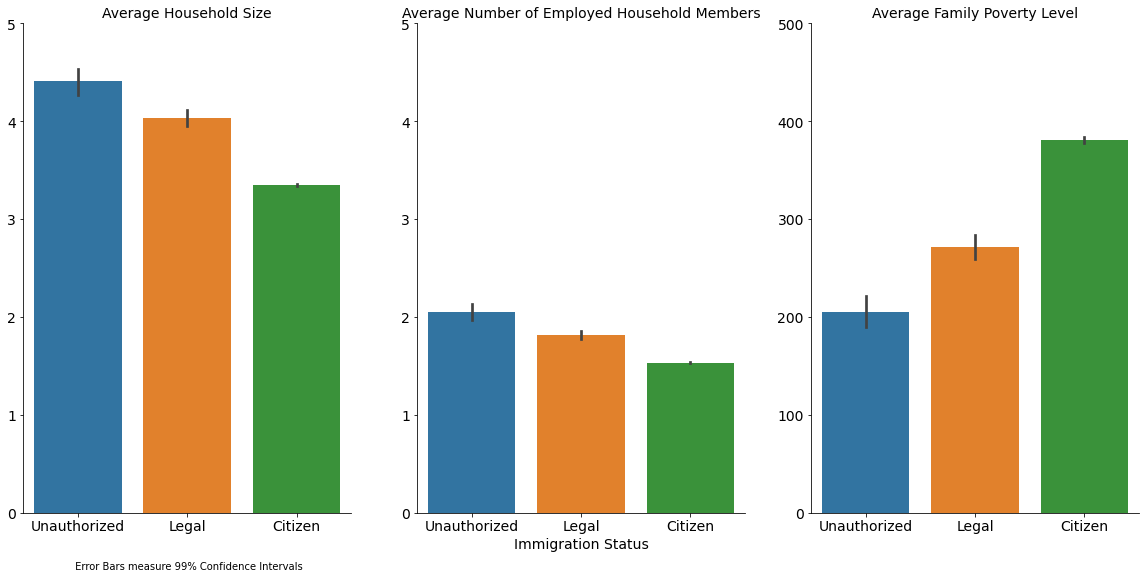

In [104]:
plt.figure(figsize = (20, 9))
plt.subplots_adjust(hspace = .1)
plt.suptitle("", fontsize = 14)

plt.subplot(1, 3, 1)

sns.barplot(x = 'legal', y = 'num_hh', data = sipp2008w2_all, ci = 99)
plt.ylim(0,5)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.xlabel(' \n \n Error Bars measure 99% Confidence Intervals')
plt.title('Average Household Size', fontsize = 14)
#sw
sns.despine()

plt.subplot(1, 3, 2)

sns.barplot(x = 'legal', y = 'hh_workers', data = sipp2008w2_all[sipp2008w2_all['job'].notnull()], ci = 99)
plt.ylim(0,5)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.xlabel('Immigration Status', fontsize = 14)
plt.title('Average Number of Employed Household Members', fontsize = 14)

sns.despine()

plt.subplot(1, 3, 3)

sns.barplot(x = 'legal', y = 'poverty', data = sipp2008w2_all, ci = 99)
plt.ylim(0,500)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.xlabel('')
plt.title('Average Family Poverty Level', fontsize = 14)

sns.despine()

plt.show()

The average unauthorized noncitizen are poorer and live in larger households than the average legal noncitizen and the average citizen, respectively. They also live in households where a greater number of them have jobs than legal noncitizens and citizens. __A caveat: these figures were not created with survey weights.__ 

#### Is Everyone in Household Related? Is There a Citizen in the Household?

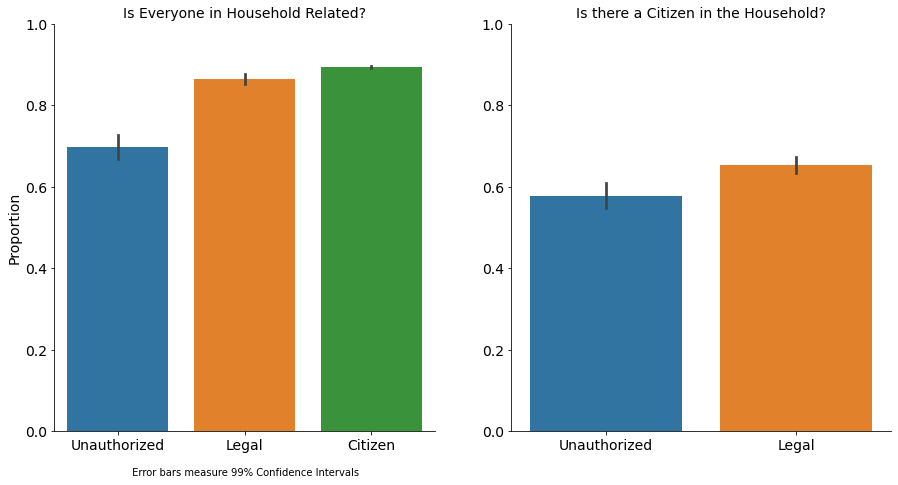

In [105]:
# Plotting 'hh_related' and 'hhcitizen' as barplots

plt.figure(figsize = (15, 7.5))
plt.subplots_adjust(hspace = .1)

plt.subplot(1, 2, 1)


sns.barplot(x = 'legal', y = 'hh_related', data = sipp2008w2_all, ci = 99)
plt.ylim(0,1)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Proportion', fontsize = 14)
plt.xlabel('\n Error bars measure 99% Confidence Intervals')
plt.title('Is Everyone in Household Related?', fontsize = 14)
sns.despine()

plt.subplot(1, 2, 2)

sns.barplot(x = 'unauthorized', y = 'hhcitizen', data = sipp2008w2_all, order = [1, 0], ci = 99)
plt.ylim(0,1)
plt.xticks(np.arange(2), ('Unauthorized', 'Legal'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.xlabel('')
plt.title('Is there a Citizen in the Household?', fontsize = 14)
sns.despine()

plt.show()

The left-hand plot above shows the proportion of people in each class of immigration status who live in a household where everyone is related. Under 70% of unauthorized noncitizens reside in a household where everyone is related, but over 80% of legal noncitizens and citizens live in homes where everyone is related. 

The plot on the right side focuses only on the noncitizen population and shows the proportions of unauthorized and legal noncitizens, respectively, who live with a citizen. Fewer unauthorized noncitizens live with a citizen than lawfully present noncitizens. 

#### Gender, Ethnicity, Age

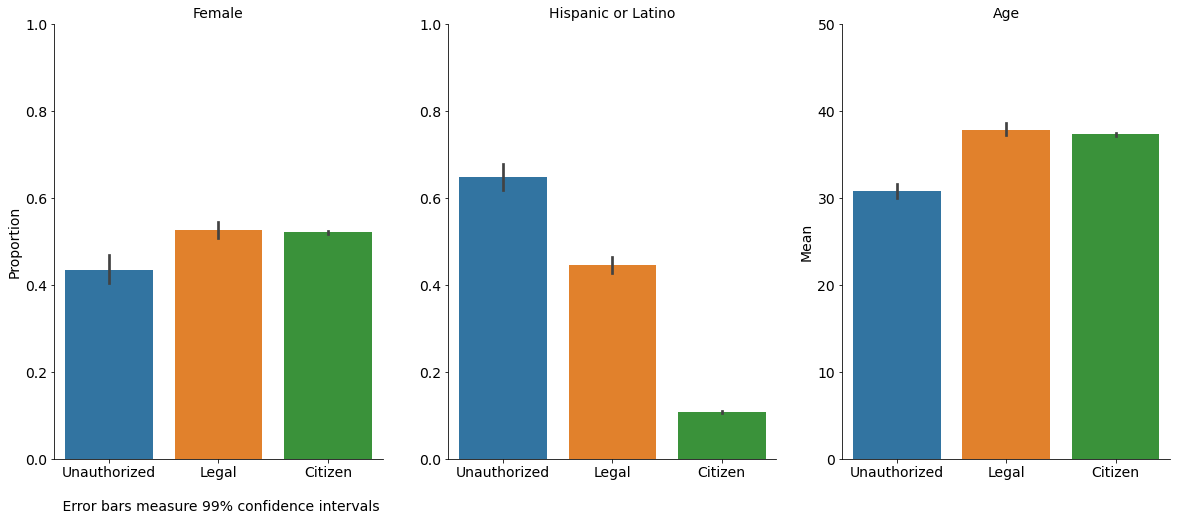

In [106]:
plt.figure(figsize = (20, 8))
plt.subplots_adjust(hspace = .1)
plt.suptitle("", fontsize = 14)

plt.subplot(1, 3, 1)

sns.barplot(x = 'legal', y = 'female', data = sipp2008w2_all, ci = 99)
plt.ylim(0,1)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Proportion', fontsize = 14)
plt.xlabel('\n Error bars measure 99% confidence intervals', fontsize = 14)
plt.title('Female', fontsize = 14)
#plt.figtext(0.5, 0.001, 'Error Bars Measure 99% Confidence Intervals', wrap=True, horizontalalignment='center', fontsize=12)

sns.despine()

plt.subplot(1, 3, 2)

sns.barplot(x = 'legal', y = 'hispanic_latino', data = sipp2008w2_all, ci = 99)
plt.ylim(0,1)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.xlabel('')
plt.title('Hispanic or Latino', fontsize = 14)

sns.despine()

plt.subplot(1, 3, 3)
sns.barplot(x = 'legal', y = 'tage', data = sipp2008w2_all, ci = 99)
plt.ylim(0,50)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Mean', fontsize = 14)
plt.xlabel('')
plt.title('Age', fontsize = 14)

sns.despine()

plt.show()


Compared to legal noncitizens and citizens, the unauthorized population has relatively fewer females. Also, Hispanics and Latinos make up *much* greater shares of the unauthorized and legal noncitizen population than they do among citizens. Unauthorized noncitizens are also younger, on average, than legal noncitizens and citizens. 

#### Education and Length of U.S. Residence

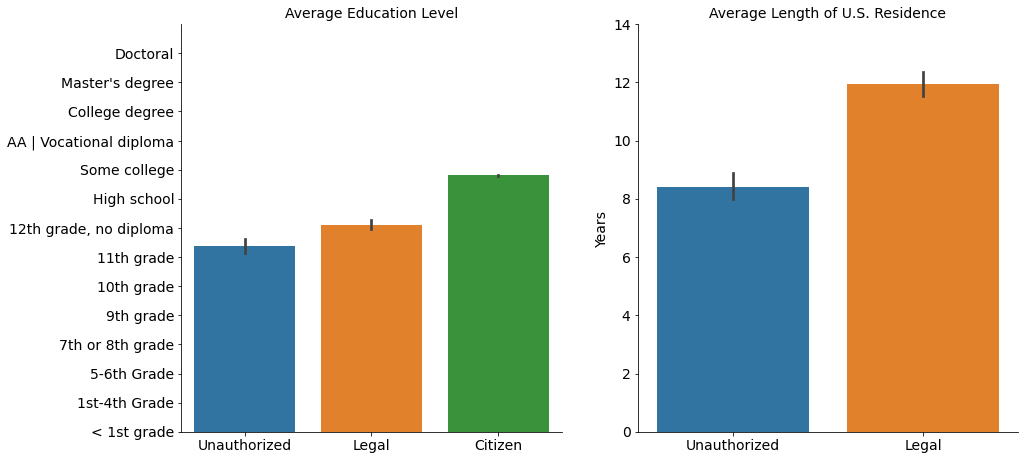

In [107]:
# Plotting education and length of U.S. residence

plt.figure(figsize = (15, 7.5))
plt.subplots_adjust(hspace = .1)

plt.subplot(1, 2, 1)


sns.barplot(x = 'legal', y = 'educ', data = sipp2008w2_all[sipp2008w2_all['educ']> -1], ci = 99)
plt.ylim(0,14)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(np.arange(14), ('< 1st grade', '1st-4th Grade', '5-6th Grade', '7th or 8th grade', '9th grade', '10th grade', 
                           '11th grade', '12th grade, no diploma', 'High school', 'Some college', 
                           'AA | Vocational diploma', 'College degree', "Master's degree",
                           "Doctoral"), fontsize = 14)
plt.ylabel('')
plt.xlabel('')
plt.title('Average Education Level', fontsize = 14)
sns.despine()

plt.subplot(1, 2, 2)

sns.barplot(x = 'unauthorized', y = 'years_us', data = sipp2008w2_all[sipp2008w2_all['years_us']> -1], order = [1, 0], ci = 99)
plt.ylim(0,14)
plt.xticks(np.arange(2), ('Unauthorized', 'Legal'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Years', fontsize = 14)
plt.xlabel('')
plt.title('Average Length of U.S. Residence', fontsize = 14)
sns.despine()

plt.show()

Citizens have higher education levels than noncitizens, and especially unauthorized immigrants. Unauthorized immigrants have an 11th grade education. They have also lived in the U.S. an average of over seven years while lawfully present immigrants have lived here approximately 11 years. 

#### Insurance 

In [108]:
insurance = sipp2008w2_all.groupby('legal').insurance.value_counts(normalize = True).rename('proportion').reset_index()

In [109]:
{1: 'Uninsured', 2: 'Other', 3: 'Privately purchased insurance',
                    4: 'Employer-sponsored/Union Insurance', 5: 'Military/Veterans insurance',
                    6: 'Medicaid/CHIP/Medicare'}

{1: 'Uninsured',
 2: 'Other',
 3: 'Privately purchased insurance',
 4: 'Employer-sponsored/Union Insurance',
 5: 'Military/Veterans insurance',
 6: 'Medicaid/CHIP/Medicare'}

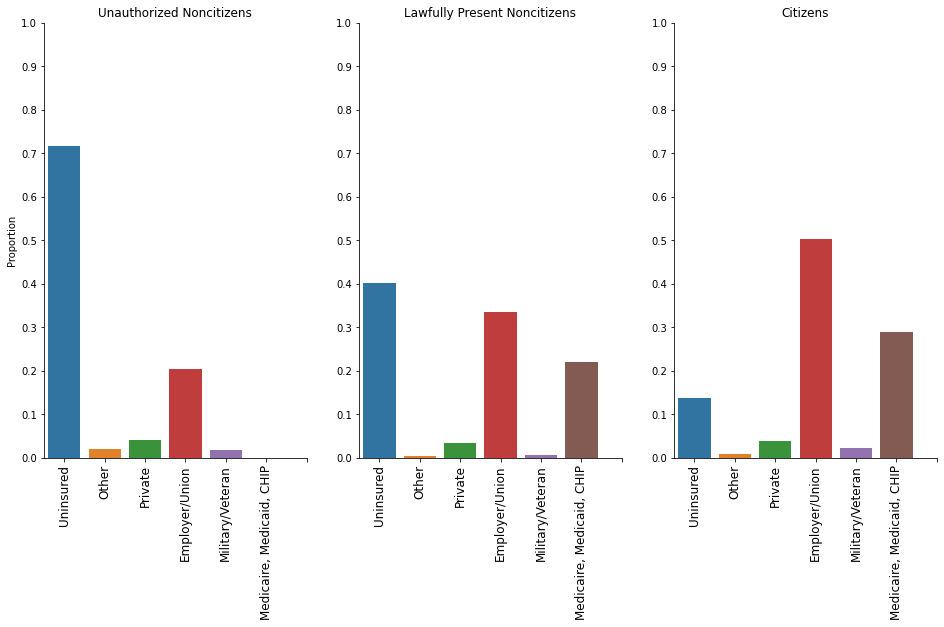

In [110]:
plt.figure(figsize = (16, 8))

plt.subplot(1, 3, 1)
sns.barplot(x = 'insurance', y = 'proportion', data = insurance[insurance['legal'] == 0])
plt.xlabel('')
plt.xticks(np.arange(7),
           ['Uninsured', 'Other', 'Private', 'Employer/Union', 'Military/Veteran', 'Medicaire, Medicaid, CHIP', ''],
          rotation = 90, size = 12 )
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.ylabel('Proportion')
plt.title('Unauthorized Noncitizens')
sns.despine()

plt.subplot(1, 3, 2)

sns.barplot(x = 'insurance', y = 'proportion', data = insurance[insurance['legal'] == 1])
plt.xlabel('')
plt.xticks(np.arange(7),
           ['Uninsured', 'Other', 'Private', 'Employer/Union', 'Military/Veteran', 'Medicaire, Medicaid, CHIP', ''],
          rotation = 90, size = 12 )
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.ylabel('')
plt.title('Lawfully Present Noncitizens')
sns.despine()

plt.subplot(1, 3, 3)

sns.barplot(x = 'insurance', y = 'proportion', data = insurance[insurance['legal'] == 2])
plt.xlabel('')
plt.xticks(np.arange(7),
           ['Uninsured', 'Other', 'Private', 'Employer/Union', 'Military/Veteran', 'Medicaire, Medicaid, CHIP', ''],
          rotation = 90, size = 12 )
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.ylabel('')
plt.title('Citizens')
sns.despine()

plt.show()

There are huge differences between the immigration status groups when it comes to insurance coverage. About 15% of citizens are uninsured, while between 40% and 50% of legal noncitizens do not have insurance coverage, but 70% of unauthorized citizens are without coverage! Among lawfully present noncitizens and citizens, the distribution of coverage also varies in meaningful ways. The majority of citizens get their insurance through their employers or from public programs like Medicare, Medicaid, or the Children's Health Insurance Program (CHIP). Fewer lawfully present noncitizens have job-related insurance and fewer are also on public insurance programs. 

#### Employment

In [111]:
industry = sipp2008w2_all.groupby('legal').job.value_counts(normalize = True).rename('proportion').reset_index()

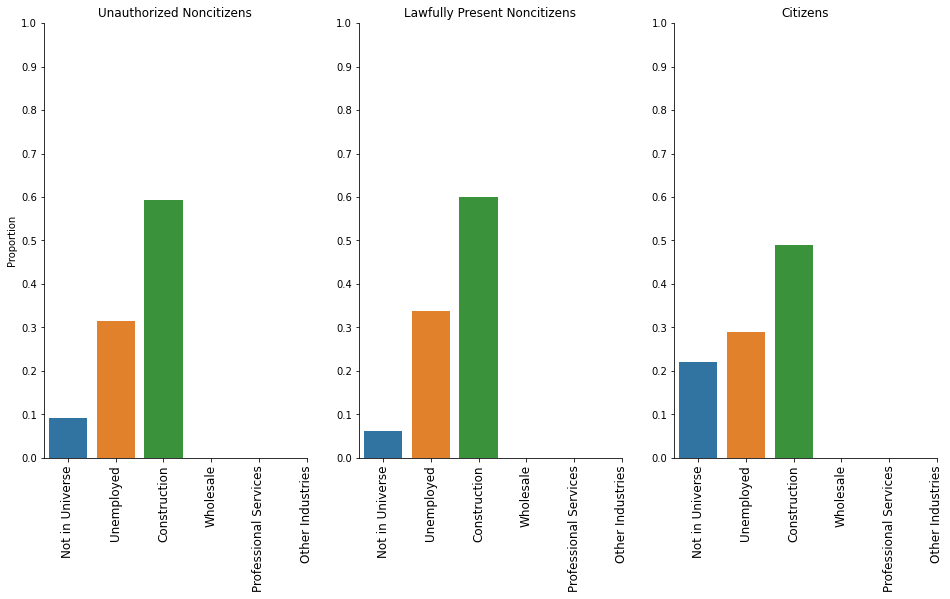

In [112]:
plt.figure(figsize = (16, 8))

plt.subplot(1, 3, 1)
sns.barplot(x = 'job', y = 'proportion', data = industry[industry['legal'] == 0])
plt.xlabel('')
plt.xticks(np.arange(6), 
          ['Not in Universe', 'Unemployed', 'Construction', 'Wholesale', 'Professional Services', 'Other Industries'],
          rotation = 90, size = 12)
plt.ylim(0, 1)
plt.ylabel('Proportion')
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title('Unauthorized Noncitizens')
sns.despine()

plt.subplot(1,3,2)
sns.barplot(x = 'job', y = 'proportion', data = industry[industry['legal'] == 1])
plt.xlabel('')
plt.xticks(np.arange(6), 
          ['Not in Universe', 'Unemployed', 'Construction', 'Wholesale', 'Professional Services', 'Other Industries'],
          rotation = 90, size = 12)
plt.ylim(0, 1)
plt.ylabel('')
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title('Lawfully Present Noncitizens')
sns.despine()

plt.subplot(1,3,3)
sns.barplot(x = 'job', y = 'proportion', data = industry[industry['legal'] == 2])
plt.xlabel('')
plt.xticks(np.arange(6), 
          ['Not in Universe', 'Unemployed', 'Construction', 'Wholesale', 'Professional Services', 'Other Industries'],
          rotation = 90, size = 12)
plt.ylim(0, 1)
plt.ylabel('')
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title('Citizens')
sns.despine()

plt.show()

Comparing the immigration status groups by job industry, there are two meaningful differences between the groups: 1) Unauthorized immigrants report higher rates of unemployment (though the differences in unemployment rates are less than 10% across the groups), and 2) a greater share of unauthorized immigrants work in construction than legal noncitizens or citizens. 

#### Region of Birth

In [113]:
birthregion = sipp2008w2_all.groupby('legal').region_birth.value_counts(normalize = True).rename('proportion').reset_index()

In [114]:
pd.crosstab(sipp2008w2_all['region_birth'], columns = 'counts')

col_0,counts
region_birth,
-1,20757
1,66255
2,609
3,683
4,813
5,960
6,729
7,1262
8,457


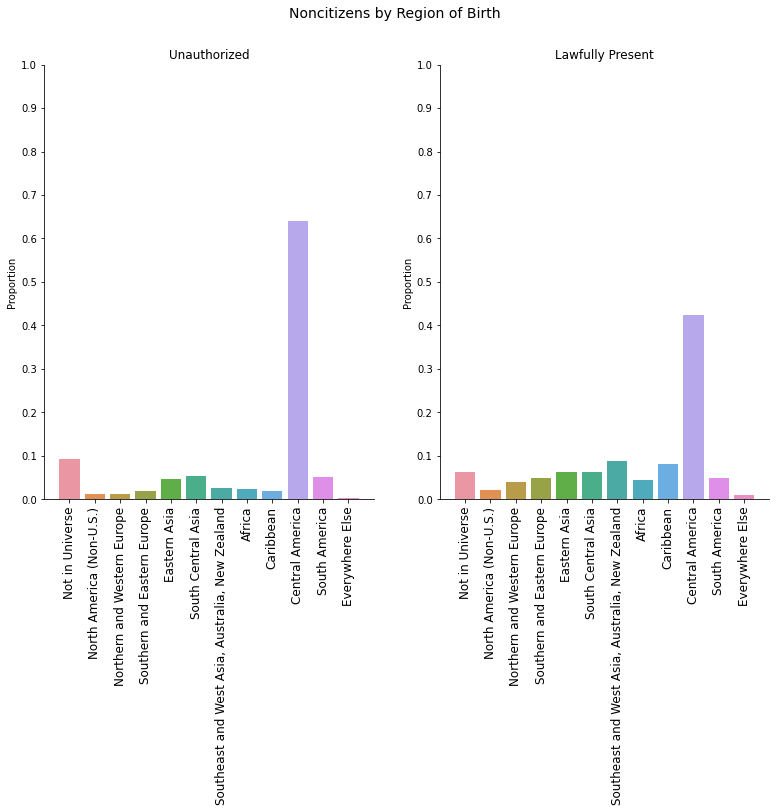

In [115]:
plt.figure(figsize = (13, 8))
plt.suptitle('Noncitizens by Region of Birth', size = 14)

plt.subplot(1, 2, 1)
sns.barplot(x = 'region_birth', y = 'proportion', data = birthregion[birthregion['legal'] == 0])
plt.xlabel('')
plt.xlim(-1, 12)
plt.xticks(np.arange(0, 12, step = 1), 
           ['Not in Universe','North America (Non-U.S.)', 'Northern and Western Europe', 'Southern and Eastern Europe', 
            'Eastern Asia', 'South Central Asia', 'Southeast and West Asia, Australia, New Zealand', 
            'Africa', 'Caribbean', 'Central America', 'South America', 'Everywhere Else'],
          rotation = 90, size = 12)
plt.ylim(0, 1)
plt.ylabel('Proportion')
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title('Unauthorized')
sns.despine()

plt.subplot(1, 2, 2)
sns.barplot(x = 'region_birth', y = 'proportion', data = birthregion[birthregion['legal'] == 1])
plt.xlabel('')
plt.xlim(-1, 12)
plt.xticks(np.arange(0, 12, step = 1), 
           ['Not in Universe', 'North America (Non-U.S.)', 'Northern and Western Europe', 'Southern and Eastern Europe', 
            'Eastern Asia', 'South Central Asia', 'Southeast and West Asia, Australia, New Zealand', 
            'Africa', 'Caribbean', 'Central America', 'South America', 'Everywhere Else'],
          rotation = 90, size = 12)
plt.ylim(0, 1)
plt.ylabel('Proportion')
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title('Lawfully Present')
sns.despine()


The strong majority of unauthorized immigrants, roughly 70%, are from Central America and it is likely that most of them are from Mexico. Unfortunately, we are unable to confirm this in the data because the SIPP does not provide country of birth for its respondents in its public use files, with the exception of the United States. The rest of possibilities are regional in nature. We see a simiilar trend in lawfully present noncitizens, as almost half of them are also from Central America.  The 'everywhere else' category is undefined in the SIPP documentation, so we cannot determine precisely where those respondents were born. 

#### English Proficiency

In [116]:
proficiency = sipp2008w2_all.groupby('legal').english.value_counts(normalize = True).rename('proportion').reset_index()

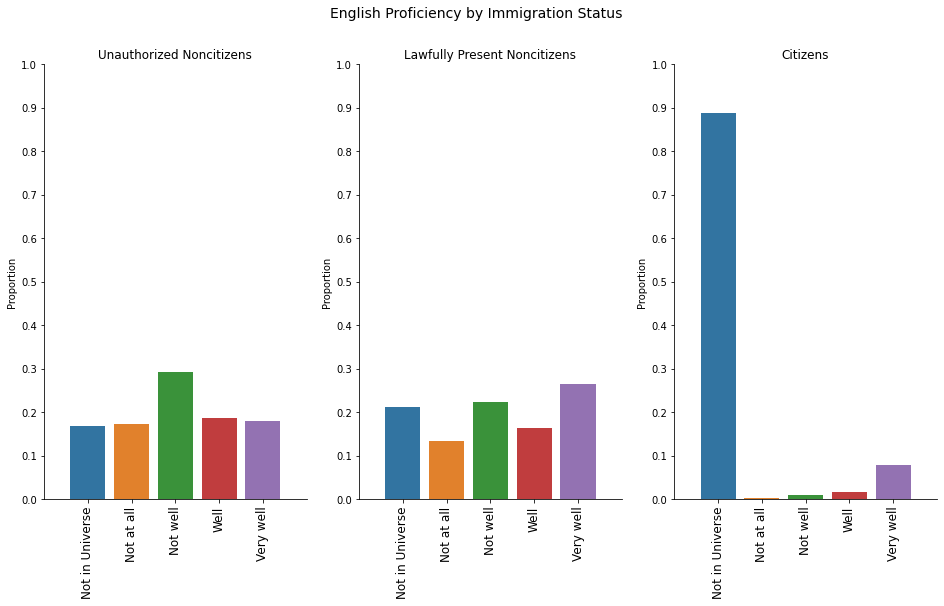

In [117]:
plt.figure(figsize = (16, 8))
plt.suptitle('English Proficiency by Immigration Status', size = 14)

plt.subplot(1, 3, 1)
sns.barplot(x = 'english', y = 'proportion', data = proficiency[proficiency['legal'] == 0])
plt.xlabel('')
plt.xlim(-1, 5)
plt.xticks(np.arange(5), ['Not in Universe', 'Not at all', 'Not well', 'Well', 'Very well'],
           rotation = 90, size = 12)
plt.ylim(0, 1)
plt.ylabel('Proportion')
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title('Unauthorized Noncitizens')
sns.despine()

plt.subplot(1, 3, 2)
sns.barplot(x = 'english', y = 'proportion', data = proficiency[proficiency['legal'] == 1])
plt.xlabel('')
plt.xlim(-1, 5)
plt.xticks(np.arange(5), ['Not in Universe', 'Not at all', 'Not well', 'Well', 'Very well'],
           rotation = 90, size = 12)
plt.ylim(0, 1)
plt.ylabel('Proportion')
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title('Lawfully Present Noncitizens')
sns.despine()

plt.subplot(1, 3, 3)
sns.barplot(x = 'english', y = 'proportion', data = proficiency[proficiency['legal'] == 2])
plt.xlabel('')
plt.xlim(-1, 5)
plt.xticks(np.arange(5), ['Not in Universe', 'Not at all', 'Not well', 'Well', 'Very well'],
           rotation = 90, size = 12)
plt.ylim(0, 1)
plt.ylabel('Proportion')
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title('Citizens')
sns.despine()


plt.show()

Citizens' proficiency in English is noticeably better than that of noncitizens, but legal noncitizens are marginally better English speakers than unauthorized immigrants. About half of legal noncitizens report speaking English very well, but only 30% of unauthorized immigrants do. 

#### Functional Limitations

In [118]:
limitations = sipp2008w2_all.groupby('legal').limitations.value_counts(normalize = True).rename('proportion').reset_index()

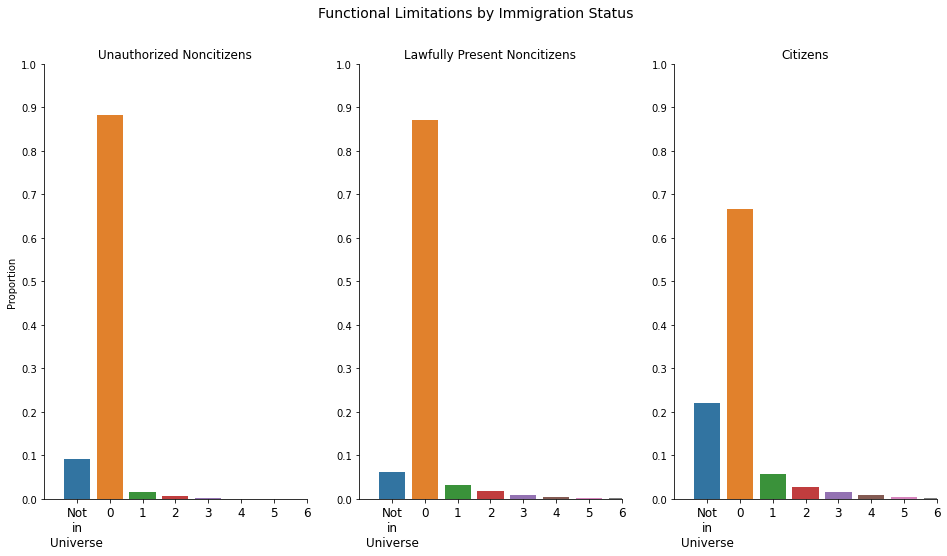

In [119]:
plt.figure(figsize = (16, 8))
plt.suptitle('Functional Limitations by Immigration Status', size = 14)

plt.subplot(1, 3, 1)
sns.barplot(x = 'limitations', y = 'proportion', data = limitations[limitations['legal'] == 0])
plt.xlabel('')
plt.xlim(-1, 6)
plt.xticks(np.arange(8), ['Not\nin\nUniverse', 0, 1, 2, 3, 4, 5, 6], size = 12)
plt.ylim(0, 1)
plt.ylabel('Proportion')
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title('Unauthorized Noncitizens')
sns.despine()

plt.subplot(1, 3, 2)
sns.barplot(x = 'limitations', y = 'proportion', data = limitations[limitations['legal'] == 1])
plt.xlabel('')
plt.xlim(-1, 6)
plt.xticks(np.arange(8), ['Not\nin\nUniverse', 0, 1, 2, 3, 4, 5, 6], size = 12)
plt.ylim(0, 1)
plt.ylabel('')
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title('Lawfully Present Noncitizens')
sns.despine()

plt.subplot(1, 3, 3)
sns.barplot(x = 'limitations', y = 'proportion', data = limitations[limitations['legal'] == 2])
plt.xlabel('')
plt.xlim(-1, 6)
plt.xticks(np.arange(8), ['Not\nin\nUniverse', 0, 1, 2, 3, 4, 5, 6], size = 12)
plt.ylim(0, 1)
plt.ylabel('')
plt.yticks(np.arange(0, 1.1, step = 0.1))
plt.title('Citizens')
sns.despine()


plt.show()

Citizens are about 20% more likely to have functional disabilities than noncitizens. But, noncitizens do not vary with resepct to reporting them. 

In [120]:
pd.crosstab(sipp2008w2_all['tbrstate'], columns = "counts")

col_0,counts
tbrstate,
-1,20757
1,1242
2,147
4,806
5,682
...,...
567,1262
568,457
569,1009


### Focusing Data on Noncitizens and Mitigating Outliers

In [121]:
# Reducing data to noncitizens

sipp_noncitizens = sipp2008w2_all[sipp2008w2_all['unauthorized'].notnull()]

In [122]:
numeric_features = ['years_us', 'educ', 'poverty', 'num_hh', 'hh_workers']

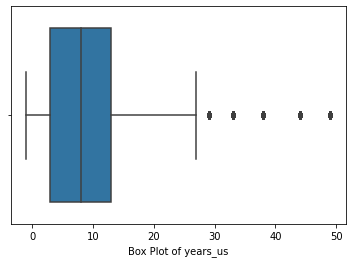

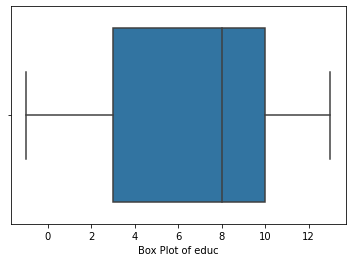

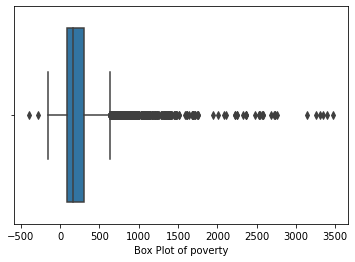

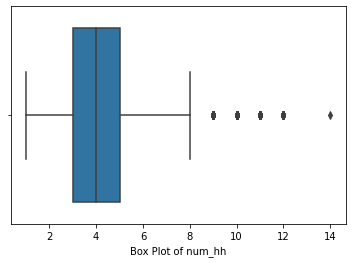

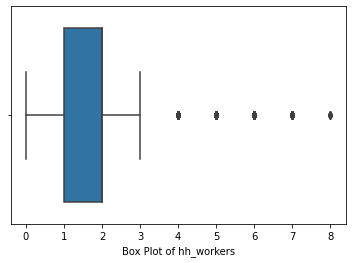

In [123]:
# Checking for outliers in numeric features among noncitizens

for feature in numeric_features:
    sns.boxplot(x = feature, data = sipp_noncitizens)
    plt.xlabel('Box Plot of '+ feature)
    plt.show()

Most of the numeric features have outliers, which we will mitigate here. Education does not have extreme values here. 

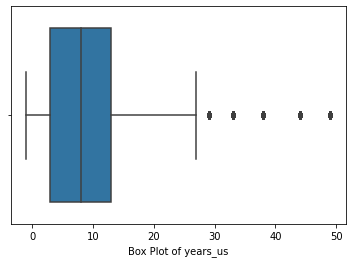

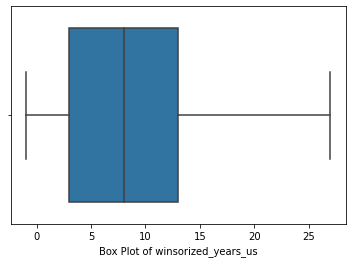

In [124]:
sipp_noncitizens['winsorized_years_us'] = winsorize(sipp_noncitizens['years_us'], (0.0, 0.07))

sns.boxplot(x = 'years_us', data = sipp_noncitizens)
plt.xlabel('Box Plot of years_us')
plt.show()

sns.boxplot(x = 'winsorized_years_us', data = sipp_noncitizens)
plt.xlabel('Box Plot of winsorized_years_us')

plt.show()

The feature measuring how many years noncitizens have lived in the U.S. has extreme values at the right tail of the distribution and I capped it at the 93rd percentile.  

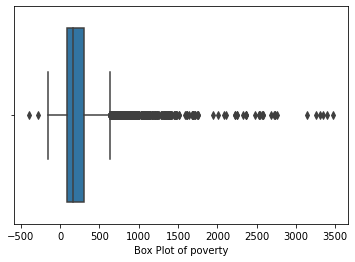

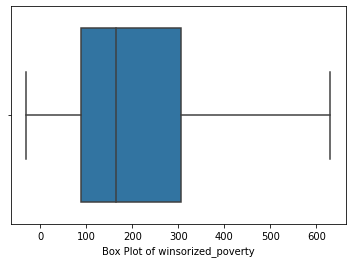

In [125]:
sipp_noncitizens['winsorized_poverty'] = winsorize(sipp_noncitizens['poverty'], (0.001, 0.08))

sns.boxplot(x = 'poverty', data = sipp_noncitizens)
plt.xlabel('Box Plot of poverty')
plt.show()

sns.boxplot(x = 'winsorized_poverty', data = sipp_noncitizens)
plt.xlabel('Box Plot of winsorized_poverty')

plt.show()

The __poverty__ feature, which measures the ratio of family income to the poverty threshold, has extreme values on both ends of the distribution. I capped the left, or lower end, at the .001st percentile and the right, or higher end, at the 92nd percentile. 

The household size feature, 'num_hh', has extreme ends on the right end of the distribution. I am going to cap the feature at the 96th percentile.

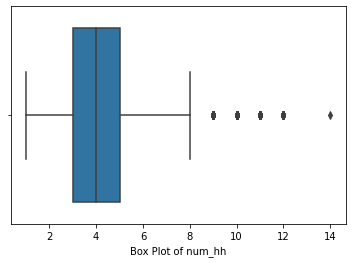

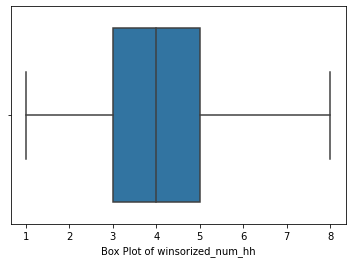

In [126]:
sipp_noncitizens['winsorized_num_hh'] = winsorize(sipp_noncitizens['num_hh'], (0.0, 0.04))

sns.boxplot(x = 'num_hh', data = sipp_noncitizens)
plt.xlabel('Box Plot of num_hh')
plt.show()

sns.boxplot(x = 'winsorized_num_hh', data = sipp_noncitizens)
plt.xlabel('Box Plot of winsorized_num_hh')

plt.show()

The feature measuring the number of workers in the household has extreme measures on the right end of the distribution and I capped it at the 90th percentile. 

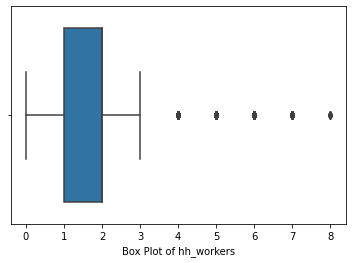

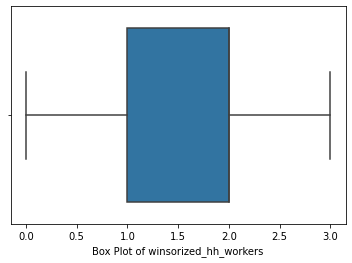

In [127]:
sipp_noncitizens['winsorized_hh_workers'] = winsorize(sipp_noncitizens['hh_workers'], (0.0, 0.1))

sns.boxplot(x = 'hh_workers', data = sipp_noncitizens)
plt.xlabel('Box Plot of hh_workers')
plt.show()

sns.boxplot(x = 'winsorized_hh_workers', data = sipp_noncitizens)
plt.xlabel('Box Plot of winsorized_hh_workers')

plt.show()

## Feature Selection

|__Variables from Literature__|__Variables__ |
|-|-|
| Family poverty level | winsorized_poverty |
| education level |	educ |
| Born in Mexico/Region of Birth | region_birth |
| Years of U.S. residence |	winsorized_years_us |
| age |	tage |
| gender | esex |
| Number of functional limitations (disabilities) |	limitations |
| Year of US entry | years_us |
| Job industry classification | job |
| employment status | job |
| State of residence | noncitizen_state, nc_state |
| Ownership or rental of residence | etenure | 
| Presence of at least one citizen in household | hhcitizen |
| Number of occupants in the household (< or >= six occupants) | winsorized_num_hh |
| Whether all household occupants are related |	hh_related |
| Number of workers in household | winsorized_hh_workers |
| Health insurance coverage status | insurance |
| Gender | female |
| Ethnicity-Hispanic or Latino Origin | hispanic_latino |
| English language proficiency	| english |
| Are they married or not |	married |
| parental status (has children) | rdesgpnt |

### Class Imbalance

In [128]:
pd.crosstab(sipp_noncitizens['unauthorized'], columns = "proportion", normalize = True)

col_0,proportion
unauthorized,
0.0,0.72067
1.0,0.27933


Our target has a class imbalance, as roughly 72% of noncitizens are likely legal and 28% are likely unauthorized. I am going to use the Synthetic Minority Oversampling Technique (S.M.O.T.E) to balance the target and then train the models. We'll use a combination of under-sampling the majority class and over-sampling the minority class with SMOTE-NC because we have a mix of continuous and nominal features. 

### Testing Each of the Three Models

I am going to test each model's ability to classify noncitizens using Logistic Regression to determine which one we should use going forward. Or, if none of them are impressive, I'll build one that borrows features from each of the three. There is considerable overlap between all of them, so they may vary only slightly.

In [129]:
# Let's assign the Bernoulli Naive Bayes to an object so we can save on typing

logit = LogisticRegression(random_state = 13)

In [130]:

# Let's do the same for our cross validation algorithm, which is a repeated stratified
# K-fold (repeat 3 times)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=13)

### KFF Features

- Year of US entry, (tmoveus)
- Job industry classification, (job dummies)
- State of residence, (noncitizen_state dummies)
- Family Poverty Level, (poverty)
- Ownership or rental of residence, (etenure dummies)
- Presence of at least one citizen in household, (hhcitizen)
- Number of occupants in the household (< or >= six occupants), (num_hh)
- Whether all household occupants are related, (hh_related)
- Number of workers in household, (hh_workers)
- Health insurance coverage status, (insurance dummies)
- Gender (female)
- Ethnicity-Hispanic or Latino Origin (hispanic_latino)

We need to convert the categoricals into dummies.

In [131]:
# Creating a KFF model dataframe
# Some of them will have to be converted to dummies

sipp_kff = sipp_noncitizens[["unauthorized", "pid", "tmoveus", "job", "noncitizen_state", "poverty",
           "etenure", "hhcitizen", "winsorized_num_hh", "hh_related", "winsorized_hh_workers",
           "insurance", "female", "hispanic_latino"]]

In [132]:
# Let's take the categorical variables and turn them into series of dummies

# Insurance
sipp_kff = pd.concat([sipp_kff, pd.get_dummies(sipp_kff['insurance'], prefix = 'insurance', drop_first = False)], axis=1)

# tmoveus
sipp_kff = pd.concat([sipp_kff, pd.get_dummies(sipp_kff['tmoveus'], prefix = 'tmoveus', drop_first = True)], axis=1)

# job
sipp_kff = pd.concat([sipp_kff, pd.get_dummies(sipp_kff['job'], prefix = 'job', drop_first = True)], axis=1)

# Rent/Own HH
sipp_kff = pd.concat([sipp_kff, pd.get_dummies(sipp_kff['etenure'], prefix = 'etenure', drop_first = True)], axis=1)

# States
sipp_kff = pd.concat([sipp_kff, pd.get_dummies(sipp_kff['noncitizen_state'], prefix = "ncstate", drop_first = True)], axis=1)

# Let's drop the source categoricals
sipp_kff.drop(['insurance', 'insurance_6.0', 'tmoveus', 'job', 'etenure',
               'noncitizen_state',], axis = 1, inplace = True)

In [133]:
# Setting up the target and the model

X = sipp_kff.drop(['unauthorized', 'pid'],
                      axis = 1)
y = sipp_kff['unauthorized']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)

In [134]:
X.columns

Index(['poverty', 'hhcitizen', 'winsorized_num_hh', 'hh_related',
       'winsorized_hh_workers', 'female', 'hispanic_latino', 'insurance_1.0',
       'insurance_2.0', 'insurance_3.0', 'insurance_4.0', 'insurance_5.0',
       'tmoveus_1', 'tmoveus_2', 'tmoveus_3', 'tmoveus_4', 'tmoveus_5',
       'tmoveus_6', 'tmoveus_7', 'tmoveus_8', 'tmoveus_9', 'tmoveus_10',
       'tmoveus_11', 'tmoveus_12', 'tmoveus_13', 'tmoveus_14', 'tmoveus_15',
       'tmoveus_16', 'tmoveus_17', 'tmoveus_18', 'tmoveus_19', 'tmoveus_20',
       'tmoveus_21', 'tmoveus_22', 'job_0', 'job_4', 'etenure_2', 'etenure_3',
       'ncstate_6.0', 'ncstate_12.0', 'ncstate_17.0', 'ncstate_34.0',
       'ncstate_36.0', 'ncstate_48.0'],
      dtype='object')

In [135]:
# We have to create a list of the column number for each of the categorical variables

categoricals = [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
               23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
               41, 42, 43]

In [136]:
# Let's set up a helper function to display scores

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", np.around(scores.mean(), decimals = 2))
    print("Standard Deviation:", np.around(scores.std(), decimals = 2))

In [137]:
# Setting up resampled training data to fit model and run on the test set after
# cross validation

xtrain_smote, ytrain_smote = SMOTENC(categorical_features = categoricals,
                                     sampling_strategy = 1,
                                     random_state = 13).fit_resample(X_train, y_train)

In [138]:
# Running CV on training data

imba_pipeline = make_pipeline(SMOTENC(categorical_features = categoricals,
                                      sampling_strategy = 1,
                                      random_state = 13), logit)

#Let's round the scores to two decimals
kff_scores = np.around(cross_val_score(imba_pipeline, X_train, y_train, cv = cv, n_jobs = -1), decimals = 2)
display_scores(kff_scores)

Scores: [0.74 0.73 0.71 0.71 0.71 0.75 0.74 0.69 0.71 0.75 0.72 0.72 0.69 0.7
 0.74 0.73 0.72 0.73 0.71 0.74 0.72 0.74 0.7  0.72 0.7  0.7  0.72 0.71
 0.7  0.74]
Mean: 0.72
Standard Deviation: 0.02


In [139]:
y_pred = logit.fit(xtrain_smote, ytrain_smote).predict(X_test)

In [140]:
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Assigning columns names
cm_df = pd.DataFrame(cm,
                    columns = ['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive'])

cm_df

,Predicted Negative,Predicted Positive
Actual Negative,844,256
Actual Positive,204,218


In [141]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
    
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print("Evaluation Metrics:")
    
    # false positive rate
    
    false_positive_rate = FP / (FP + TN) 
    
    # false negative rate
    
    false_negative_rate = FN / (TP + FN) 
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN)) 
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN)) 
    
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print("False Positive Rate: {}".format(round(false_positive_rate, 1)))
    print("False Negative Rate: {}".format(round(false_negative_rate, 1)))
    print(f'Sensitivity|Recall: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')

In [142]:
confusion_metrics(cm)

Evaluation Metrics:
--------------------------------------------------
Accuracy: 0.7
False Positive Rate: 0.2
False Negative Rate: 0.5
Sensitivity|Recall: 0.52
Specificity: 0.77
Precision: 0.46


In [143]:
# Let's create a dictionary capturing modeel metrics 

kff_metrics = {'Accuracy': .7, 'False Positive Rate': .2, 
           'False Negative Rate': .5, 'Sensitivity | Recall': .52, 
           'Specificity': .77, 'Precision': .46}

kff = pd.DataFrame.from_dict(kff_metrics, orient = 'index', columns = ['KFF'])

The KFF model shows OK performance.

The KFF model has room for improvement, only correctly classifying 70% of immigrants. The Sensitivity/Recall score shows that it only correctly classifies 52% of unauthorized citizens. Of those that the model labeled as unauthorized, 77% are actually unauthorized. 

### Capps et al 
- world region of birth (region_birth dummies)
- duration of US residence (years_us)
- English language proficiency (english dummies)
- age (tage)
- sex (female)
- are they married or not (married)
- parental status (has children) (rdesgpnt)
- household size (num_hh)
- educational attainment (educ dummies)
- homeownership (etenure dummies)
- insurance coverage (insurance dummies)
- labor force status (job dummies)
- income-to-poverty ratio (poverty)
- US state/region of residence (noncitizen_state dummies)

In [144]:
sipp_capps = sipp_noncitizens[["unauthorized", "pid", 'region_birth', "winsorized_years_us",
                               "english", "tage",
                               "female", "married", "rdesgpnt", "winsorized_num_hh",
                               "educ", "insurance", "job", "etenure", 
                               "winsorized_poverty",  "noncitizen_state"  
]]

In [145]:
# Let's take the categorical variables and turn them into series of dummies

# Insurance
sipp_capps = pd.concat([sipp_capps, pd.get_dummies(sipp_capps['insurance'], prefix = 'insurance', drop_first = False)], axis=1)

# region_birth
sipp_capps = pd.concat([sipp_capps, pd.get_dummies(sipp_capps['region_birth'], prefix = 'region', drop_first = True)], axis=1)

# english
sipp_capps = pd.concat([sipp_capps, pd.get_dummies(sipp_capps['english'], prefix = 'english', drop_first = True)], axis=1)

# rdesgpnt
sipp_capps = pd.concat([sipp_capps, pd.get_dummies(sipp_capps['rdesgpnt'], prefix = 'rdesgpnt', drop_first = True)], axis=1)

# educ
sipp_capps = pd.concat([sipp_capps, pd.get_dummies(sipp_capps['educ'], prefix = 'educ', drop_first = True)], axis=1)

# job
sipp_capps = pd.concat([sipp_capps, pd.get_dummies(sipp_capps['job'], prefix = 'job', drop_first = True)], axis=1)

# Rent/Own HH
sipp_capps = pd.concat([sipp_capps, pd.get_dummies(sipp_capps['etenure'], prefix = 'etenure', drop_first = True)], axis=1)

# States
sipp_capps = pd.concat([sipp_capps, pd.get_dummies(sipp_capps['noncitizen_state'], prefix = "ncstate", drop_first = True)], axis=1)

# Let's drop the source categoricals

sipp_capps.drop(['insurance', 'insurance_6.0', 'region_birth', 'english', 'rdesgpnt',
                 'educ', 'job', 'etenure', 'noncitizen_state',], 
                axis = 1, inplace = True)

In [146]:
# Setting up the target and the model

X = sipp_capps.drop(['unauthorized', 'pid'],
                      axis = 1)
y = sipp_capps['unauthorized']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)

In [147]:
X.columns

Index(['winsorized_years_us', 'tage', 'female', 'married', 'winsorized_num_hh',
       'winsorized_poverty', 'insurance_1.0', 'insurance_2.0', 'insurance_3.0',
       'insurance_4.0', 'insurance_5.0', 'region_2', 'region_3', 'region_4',
       'region_5', 'region_6', 'region_7', 'region_8', 'region_9', 'region_10',
       'region_11', 'region_12', 'english_0', 'english_1', 'english_2',
       'english_3', 'rdesgpnt_1', 'rdesgpnt_2', 'educ_0', 'educ_1', 'educ_2',
       'educ_3', 'educ_4', 'educ_5', 'educ_6', 'educ_7', 'educ_8', 'educ_9',
       'educ_10', 'educ_11', 'educ_12', 'educ_13', 'job_0', 'job_4',
       'etenure_2', 'etenure_3', 'ncstate_6.0', 'ncstate_12.0', 'ncstate_17.0',
       'ncstate_34.0', 'ncstate_36.0', 'ncstate_48.0'],
      dtype='object')

In [148]:
len(X.columns)

52

In [149]:
categoricals = [2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
               24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
               43, 44, 45, 46, 47, 48, 49, 50, 51]

In [150]:
# Logistic Regression, Repeated Cross-Validation, Using SMOTE ENN on each fold of the training data

imba_pipeline = make_pipeline(SMOTENC(categorical_features = categoricals,
                                       sampling_strategy = 1,
                                       random_state = 13), logit)

capps_scores = np.around(cross_val_score(imba_pipeline, X_train, y_train, cv = cv, n_jobs = -1), decimals = 2)
display_scores(capps_scores)

Scores: [0.75 0.74 0.7  0.72 0.73 0.7  0.76 0.73 0.67 0.73 0.72 0.7  0.68 0.7
 0.72 0.75 0.73 0.75 0.73 0.69 0.71 0.77 0.71 0.73 0.7  0.73 0.73 0.72
 0.72 0.71]
Mean: 0.72
Standard Deviation: 0.02


In [151]:
# Let's see the test set accuracy and the confusion matrix

xtrain_smote, ytrain_smote = SMOTENC(categorical_features = categoricals,
                                     sampling_strategy = 1,
                                     random_state = 13).fit_resample(X_train, y_train)
y_pred = logit.fit(xtrain_smote, ytrain_smote).predict(X_test)

In [152]:
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Assigning columns names
cm_df = pd.DataFrame(cm,
                    columns = ['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive'])

print(cm_df)
print("\n")
confusion_metrics(cm)

                 Predicted Negative  Predicted Positive
Actual Negative                 862                 238
Actual Positive                 192                 230


Evaluation Metrics:
--------------------------------------------------
Accuracy: 0.72
False Positive Rate: 0.2
False Negative Rate: 0.5
Sensitivity|Recall: 0.55
Specificity: 0.78
Precision: 0.49


In [153]:
capps_metrics = {
    'Accuracy': .72,
    'False Positive Rate': .2,
    'False Negative Rate': .5,
    'Sensitivity | Recall': .55,
    'Specificity': .78,
    'Precision': .49
}

capps = pd.DataFrame.from_dict(capps_metrics, orient = 'index', columns = ['Capps et al.'])

The Capps model has marginally higher accuracy, but the same false positive and false negative rates. 

### Van Hook et al
- Family poverty level (poverty)
- education level (educ dummies)
- Born in Mexico (region_birth dummies)
- Years of U.S. residence (years_us)
- age (tage)
- gender (female)
- Number of functional limitations (limitations)
- Poor health (not ACS)

In [154]:
# Creating a dataframe with the Van Hook Model

sipp_vh = sipp_noncitizens[['winsorized_poverty',
                           'educ',
                           'region_birth',
                           'winsorized_years_us',
                           'tage',
                           'female',
                           'limitations',
                           'pid',
                           'unauthorized']]

In [155]:
# Let's take the categorical variables and turn them into series of dummies

# region_birth
sipp_vh = pd.concat([sipp_vh, pd.get_dummies(sipp_vh['region_birth'], prefix = 'region', drop_first = True)], axis=1)

# educ
sipp_vh = pd.concat([sipp_vh, pd.get_dummies(sipp_vh['educ'], prefix = 'educ', drop_first = True)], axis=1)

# Let's drop the source categoricals

sipp_vh.drop(['region_birth', 'educ'], axis = 1, inplace = True)

In [156]:
# Setting up the target and the model

X = sipp_vh.drop(['unauthorized', 'pid'],
                      axis = 1)
y = sipp_vh['unauthorized']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)

In [157]:
X.columns

Index(['winsorized_poverty', 'winsorized_years_us', 'tage', 'female',
       'limitations', 'region_2', 'region_3', 'region_4', 'region_5',
       'region_6', 'region_7', 'region_8', 'region_9', 'region_10',
       'region_11', 'region_12', 'educ_0', 'educ_1', 'educ_2', 'educ_3',
       'educ_4', 'educ_5', 'educ_6', 'educ_7', 'educ_8', 'educ_9', 'educ_10',
       'educ_11', 'educ_12', 'educ_13'],
      dtype='object')

In [158]:
len(X.columns)

30

In [159]:
categoricals = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
               24, 25, 26, 27, 28, 29]

In [160]:
# Using Bernoullii Naive Bayes with SMOTE ENN and repeated cross validation, as before

imba_pipeline = make_pipeline(SMOTENC(categorical_features = categoricals,
                                      sampling_strategy = 1,
                                      random_state = 13), logit)
vh_scores = np.around(cross_val_score(imba_pipeline, X_train, y_train, cv = cv), decimals = 2)
display_scores(vh_scores)

Scores: [0.65 0.67 0.62 0.67 0.68 0.62 0.66 0.67 0.6  0.64 0.67 0.63 0.63 0.62
 0.65 0.68 0.67 0.65 0.63 0.64 0.68 0.67 0.63 0.65 0.62 0.65 0.67 0.63
 0.66 0.63]
Mean: 0.65
Standard Deviation: 0.02


In [161]:
xtrain_smote, ytrain_smote = SMOTENC(categorical_features = categoricals,
                                     sampling_strategy = 1,
                                     random_state = 13).fit_resample(X_train, y_train)

y_pred = logit.fit(xtrain_smote, ytrain_smote).predict(X_test)

In [162]:
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Assigning columns names
cm_df = pd.DataFrame(cm,
                    columns = ['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive'])

print(cm_df)
print("\n")
confusion_metrics(cm)

                 Predicted Negative  Predicted Positive
Actual Negative                 749                 351
Actual Positive                 168                 254


Evaluation Metrics:
--------------------------------------------------
Accuracy: 0.66
False Positive Rate: 0.3
False Negative Rate: 0.4
Sensitivity|Recall: 0.6
Specificity: 0.68
Precision: 0.42


In [165]:
vh_metrics = {
    'Accuracy': .66,
    'False Positive Rate': .3,
    'False Negative Rate': .4,
    'Sensitivity | Recall': .6,
    'Specificity': .68,
    'Precision': .42
}

vh = pd.DataFrame.from_dict(vh_metrics, orient = 'index', columns = ['Van Hook et al.'])

The Van Hook et al model is the worst performing model for overall accuracy, but has higher recall than the Capps model. 

In [166]:
kff_capps = kff.merge(capps, how = 'outer', left_index = True, right_index = True)

In [167]:
models_metrics = kff_capps.merge(vh, how = 'outer', left_index = True, right_index = True)

In [168]:
print(models_metrics)

                       KFF  Capps et al.  Van Hook et al.
Accuracy              0.70          0.72             0.66
False Positive Rate   0.20          0.20             0.30
False Negative Rate   0.50          0.50             0.40
Sensitivity | Recall  0.52          0.55             0.60
Specificity           0.77          0.78             0.68
Precision             0.46          0.49             0.42


The Capps et al and KFF models fair better than the Van Hook et all model, but all three leave much room for improvement. Let's pool all of the source features together and run an association matrix that can account for all of the variable types. Fortunately, the Dython library provides a way to measure bivariate relationships while accounting for the different variable types. One of its handy tools computes measures of associations contingent on the variable types, builds a matrix, and plots it as a heat map. The "association" function takes a dataframe of features and calculates the Pearson correlation between continuous and ordinal measures, a Cramer's V or Theil's U for categorical-categorical relationships, and the Correlation Ratio for categorical-continuous cases. 

### Pooling All Features

In [169]:
# Creating a target and features list for a bivariate associations heat map. 
# Some of them will have to be converted into dummies. 

sipp_ncmodel = ["unauthorized", "winsorized_poverty", "educ", "region_birth", "winsorized_years_us",
                "tage", "female", "limitations", "tmoveus", "job", "noncitizen_state", "etenure", 
                "hhcitizen", "winsorized_num_hh", "hh_related", "winsorized_hh_workers", "insurance", 
                "hispanic_latino", "english", "married", "rdesgpnt"]

Heat Map of Bivariate Associations Among the Target and Prospective Features



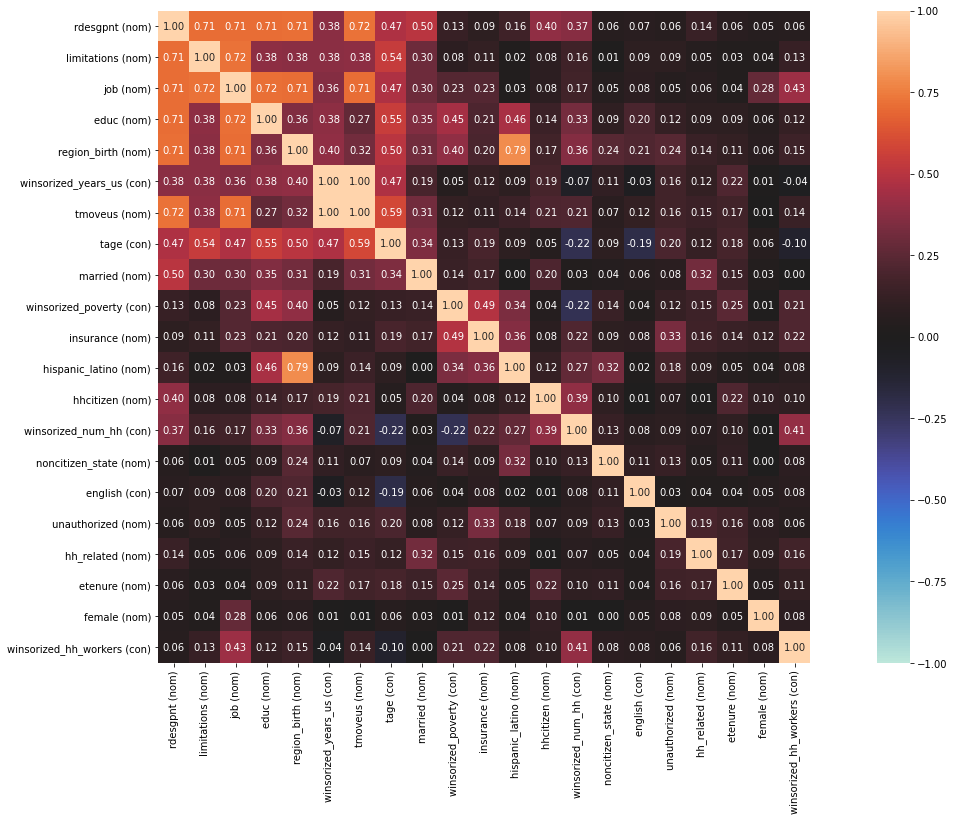

{'corr':                              rdesgpnt (nom)  limitations (nom)  job (nom)  \
 rdesgpnt (nom)                     1.000000           0.707910   0.707981   
 limitations (nom)                  0.707910           1.000000   0.718798   
 job (nom)                          0.707981           0.718798   1.000000   
 educ (nom)                         0.710835           0.384092   0.715355   
 region_birth (nom)                 0.714567           0.378528   0.707214   
 winsorized_years_us (con)          0.375847           0.382419   0.359746   
 tmoveus (nom)                      0.720056           0.384648   0.709654   
 tage (con)                         0.469330           0.542312   0.471248   
 married (nom)                      0.500273           0.298890   0.296972   
 winsorized_poverty (con)           0.131990           0.079486   0.228987   
 insurance (nom)                    0.089833           0.113605   0.226973   
 hispanic_latino (nom)              0.158703           0

In [170]:
# Using Dython to create a heat map of bivariate correlations/associations heat map between the prospective
# features and the target "unauthoriized"

print("Heat Map of Bivariate Associations Among the Target and Prospective Features\n")

associations(sipp_noncitizens[sipp_ncmodel], 
             nominal_columns = ["unauthorized", "region_birth", "female", "job", 
                                "noncitizen_state", "etenure","hhcitizen", "hh_related", "insurance", 
                                "hispanic_latino", "married", "rdesgpnt", 'tmoveus', 'educ', 'limitations'],
             clustering = True,
             mark_columns = True,
             figsize = (24, 12))

|__Feature Associations Over .7__||
|-|-|
||*rdesgpnt*|
| *tmoveus* |0.72|
|*region_birth*|0.71|
|*educ*|0.71|
|*job*|0.71|
|*limitations*|0.71|
|||
||*job*|
|*limitations*|0.72|
|*educ*|0.72|
|*tmoveus*|0.71|
|*region_birth*|0.71|
|||
||*region_birth*| 
|*hispanic_latino*|0.79|
|||
||*tmoveus*|
|*winsorized_years_us*|1|

Parental status (*rdesgpnt*) and job classification (*job*) are each strongly associated with more than several other features. But, they are not strongly associated with unauthorized status, so we can exclude them from the model. Region of birth is strongly associated with being Hispanic or Latino, which is not too surprising. Region of birth is more strongly correlated with unauthorized status, so *hispanic_latino* will be dropped from the analysis going forward. Year of moving to the U.S. and duration of U.S. residence (*winsorized_years_us*) are perfectly correlated, so I will only include duration of residence going forward. 

### Feature Selection 
 
As we saw in the association matrix, some of these features may not contribute much to a model's accuracy. I am going to use backward feature elimination with a logistic regression function as the base to eliminate features that do not reach a significance level of 5% or better (*p* <= .05).

In [171]:
# Discarding hispanic_latino, job, rdesgpnt, and tmoveus

sipp_ncmodel_cut = ["unauthorized", "winsorized_poverty", "educ", "region_birth", 
                    "winsorized_years_us", "tage", "female", "limitations",
                    "noncitizen_state", "etenure", "hhcitizen", "winsorized_num_hh", 
                    "hh_related", "winsorized_hh_workers", "insurance", "english", 
                    "married"]

sipp_ncmodel = sipp_noncitizens[sipp_ncmodel_cut]

In [172]:
# Let's take the categorical variables and turn them into series of dummies

#educ
sipp_ncmodel = pd.concat([sipp_ncmodel, pd.get_dummies(sipp_ncmodel['educ'], prefix = 'educ', drop_first = True)], axis=1)

#region_birth
sipp_ncmodel = pd.concat([sipp_ncmodel, pd.get_dummies(sipp_ncmodel['region_birth'], prefix = 'region', drop_first = True)], axis=1)

# States
sipp_ncmodel = pd.concat([sipp_ncmodel, pd.get_dummies(sipp_ncmodel['noncitizen_state'], prefix = "ncstate", drop_first = True)], axis=1)

# Rent/Own HH
sipp_ncmodel = pd.concat([sipp_ncmodel, pd.get_dummies(sipp_ncmodel['etenure'], prefix = 'etenure', drop_first = True)], axis=1)

# Insurance
sipp_ncmodel = pd.concat([sipp_ncmodel, pd.get_dummies(sipp_ncmodel['insurance'], prefix = 'insurance', drop_first = False)], axis=1)

# English
sipp_ncmodel = pd.concat([sipp_ncmodel, pd.get_dummies(sipp_ncmodel['english'], prefix = 'english', drop_first = True)], axis=1)

# Let's drop the source categoricals
sipp_ncmodel.drop(['insurance', 'insurance_6.0', 'english', 'region_birth',
                     'etenure', 'noncitizen_state', 'educ'], axis = 1, inplace = True)

In [177]:
X = sipp_ncmodel.drop(['unauthorized'], axis = 1)
y = sipp_ncmodel['unauthorized']

# Splitting the data into training and testing sets using default
# splits (75% training, 25% testing)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)

In [178]:
X.columns

Index(['winsorized_poverty', 'winsorized_years_us', 'tage', 'female',
       'limitations', 'hhcitizen', 'winsorized_num_hh', 'hh_related',
       'winsorized_hh_workers', 'married', 'educ_0', 'educ_1', 'educ_2',
       'educ_3', 'educ_4', 'educ_5', 'educ_6', 'educ_7', 'educ_8', 'educ_9',
       'educ_10', 'educ_11', 'educ_12', 'educ_13', 'region_2', 'region_3',
       'region_4', 'region_5', 'region_6', 'region_7', 'region_8', 'region_9',
       'region_10', 'region_11', 'region_12', 'ncstate_6.0', 'ncstate_12.0',
       'ncstate_17.0', 'ncstate_34.0', 'ncstate_36.0', 'ncstate_48.0',
       'etenure_2', 'etenure_3', 'insurance_1.0', 'insurance_2.0',
       'insurance_3.0', 'insurance_4.0', 'insurance_5.0', 'english_0',
       'english_1', 'english_2', 'english_3'],
      dtype='object')

In [179]:
categoricals = [3, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
               25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
               44, 45, 46, 47, 48, 49, 50, 51]

In [180]:
# Using SMOTE to undersample the majority and oversample the minority
# classes 

xtrain_smote, ytrain_smote = SMOTENC(categorical_features = categoricals,
                                    random_state = 13,
                                    n_jobs = -1).fit_resample(X_train, y_train)

In [181]:
#Backward Elimination
cols = list(xtrain_smote.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = xtrain_smote[cols]
    X_1 = sm.tools.add_constant(X_1)
    model = sm.Logit(ytrain_smote, X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

Optimization terminated successfully.
         Current function value: 0.410240
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.410394
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410396
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410418
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410586
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410761
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411233
         Iterations 7
['winsorized_poverty', 'winsorized_years_us', 'tage', 'female', 'limitations', 'h

In [182]:
len(selected_features_BE)

44

In [183]:
categoricals = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
               24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
               43]

Backward elimination eliminated seven features. Some were levels of the region of birth measure, so those will be considered as part of the model's baseline. Let's proceed with Logistic Regression, Naive Bayes, K-Nearest Neighbors, Support Vector Classifier, Random Forest, Gradient Boosting Classifier, and Multilayered Perceptron Classifiers using their default parameters. Tuning Naive Bayes and KNN with a Bayesian package is fast and efficient, but tuning other algorithms can be time-expensive. For efficiency purposes, I'll only tune the best performing algorithm to see if we can meaningfully improve its performance. 

In [184]:
X = sipp_ncmodel[selected_features_BE]
y = sipp_ncmodel['unauthorized']

# Splitting the data into training and testing sets using default
# splits (75% training, 25% testing)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13)

# Using SMOTE to undersample the majority and oversample the minority
# classes 

xtrain_smote, ytrain_smote = SMOTENC(categorical_features = categoricals,
                                    random_state = 13,
                                    n_jobs = -1).fit_resample(X_train, y_train)

In [185]:
# Let's help make coding easier, define our models

bnb = BernoulliNB()
knn = KNeighborsClassifier()
svc = svm.SVC(random_state = 13)
rfc = RandomForestClassifier(random_state = 13)
gbc = GradientBoostingClassifier(random_state = 13)
mlp = MLPClassifier(random_state = 13)

### Logistic Regression

In [186]:
imba_pipeline = make_pipeline(SMOTENC(categorical_features = categoricals,
                                      sampling_strategy = 1, random_state = 13), logit)

logit_scores = np.around(cross_val_score(imba_pipeline, X_train, y_train, cv = cv, n_jobs = -1), decimals = 2)
display_scores(logit_scores)

Scores: [0.76 0.75 0.7  0.73 0.73 0.73 0.75 0.72 0.67 0.74 0.74 0.71 0.7  0.7
 0.71 0.77 0.74 0.75 0.72 0.74 0.73 0.76 0.7  0.75 0.72 0.72 0.77 0.72
 0.72 0.73]
Mean: 0.73
Standard Deviation: 0.02


In [187]:
y_pred = logit.fit(xtrain_smote, ytrain_smote).predict(X_test)

In [188]:
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Assigning columns names
cm_df = pd.DataFrame(cm,
                    columns = ['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive'])

print(cm_df)
print("\n")
confusion_metrics(cm)

                 Predicted Negative  Predicted Positive
Actual Negative                 859                 241
Actual Positive                 190                 232


Evaluation Metrics:
--------------------------------------------------
Accuracy: 0.72
False Positive Rate: 0.2
False Negative Rate: 0.5
Sensitivity|Recall: 0.55
Specificity: 0.78
Precision: 0.49


In [189]:
logit_metrics = {'Accuracy': .72,
                'False Positive Rate': .2,
                'False Negative Rate': .5,
                'Sensitivity | Recall': .55,
                'Specificity': .78,
                'Precision': .49}

logit_metrics = pd.DataFrame.from_dict(logit_metrics, orient = 'index', columns = ['Logit'])

## Naive Bayes 

In [190]:
imba_pipeline = make_pipeline(SMOTENC(categorical_features = categoricals,
                                      sampling_strategy = 1, random_state = 13), bnb)

bnb_scores = np.around(cross_val_score(imba_pipeline, X_train, y_train, cv = cv, n_jobs = -1), decimals = 2)
display_scores(bnb_scores)

Scores: [0.71 0.72 0.67 0.69 0.69 0.68 0.69 0.68 0.67 0.68 0.68 0.69 0.68 0.65
 0.67 0.7  0.71 0.7  0.7  0.7  0.7  0.71 0.67 0.7  0.68 0.65 0.71 0.66
 0.73 0.67]
Mean: 0.69
Standard Deviation: 0.02


In [191]:
y_pred = bnb.fit(xtrain_smote, ytrain_smote).predict(X_test)

In [192]:
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Assigning columns names
cm_df = pd.DataFrame(cm,
                    columns = ['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive'])

print(cm_df)
print("\n")
confusion_metrics(cm)

                 Predicted Negative  Predicted Positive
Actual Negative                 789                 311
Actual Positive                 156                 266


Evaluation Metrics:
--------------------------------------------------
Accuracy: 0.69
False Positive Rate: 0.3
False Negative Rate: 0.4
Sensitivity|Recall: 0.63
Specificity: 0.72
Precision: 0.46


In [193]:
bnb_metrics = {'Accuracy': .69,
              'False Positive Rate': .3,
              'False Negative Rate': .4,
              'Sensitivity | Recall': .63,
              'Specificity': .72,
              'Precision': .46}

bnb_metrics = pd.DataFrame.from_dict(bnb_metrics, orient = 'index', columns = ['Naive Bayes'])

## KNN

In [194]:
imba_pipeline = make_pipeline(SMOTENC(categorical_features = categoricals,
                                      sampling_strategy = 1, random_state = 13), knn)
knn_scores = np.around(cross_val_score(imba_pipeline, X_train, y_train, cv = cv, n_jobs = -1), decimals = 2)
display_scores(knn_scores)

Scores: [0.58 0.6  0.6  0.61 0.6  0.65 0.61 0.6  0.6  0.59 0.63 0.56 0.56 0.63
 0.58 0.58 0.61 0.63 0.65 0.59 0.58 0.6  0.58 0.64 0.6  0.6  0.67 0.6
 0.59 0.61]
Mean: 0.6
Standard Deviation: 0.03


In [195]:
y_pred = knn.fit(xtrain_smote, ytrain_smote).predict(X_test)

In [196]:
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Assigning columns names
cm_df = pd.DataFrame(cm,
                    columns = ['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive'])

print(cm_df)
print("\n")
confusion_metrics(cm)

                 Predicted Negative  Predicted Positive
Actual Negative                 692                 408
Actual Positive                 170                 252


Evaluation Metrics:
--------------------------------------------------
Accuracy: 0.62
False Positive Rate: 0.4
False Negative Rate: 0.4
Sensitivity|Recall: 0.6
Specificity: 0.63
Precision: 0.38


In [197]:
knn_metrics = {'Accuracy': .62,
              'False Positive Rate': .4,
              'False Negative Rate': .4,
              'Sensitivity | Recall': .6,
              'Specificity': .63,
              'Precision': .38}

knn_metrics = pd.DataFrame.from_dict(knn_metrics, orient = 'index', columns = ['KNN'])

## SVC

In [198]:
imba_pipeline = make_pipeline(SMOTENC(categorical_features = categoricals,
                                      sampling_strategy = 1, random_state = 13), svc)
svc_scores = np.around(cross_val_score(imba_pipeline, X_train, y_train, cv = cv, n_jobs = -1), decimals = 2)
display_scores(svc_scores)

Scores: [0.61 0.6  0.6  0.64 0.61 0.59 0.61 0.59 0.61 0.6  0.62 0.58 0.6  0.62
 0.61 0.65 0.57 0.6  0.6  0.57 0.62 0.61 0.6  0.62 0.57 0.61 0.6  0.61
 0.61 0.57]
Mean: 0.6
Standard Deviation: 0.02


In [199]:
y_pred = svc.fit(xtrain_smote, ytrain_smote).predict(X_test)

In [200]:
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Assigning columns names
cm_df = pd.DataFrame(cm,
                    columns = ['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive'])

print(cm_df)
print("\n")
confusion_metrics(cm)

                 Predicted Negative  Predicted Positive
Actual Negative                 657                 443
Actual Positive                 154                 268


Evaluation Metrics:
--------------------------------------------------
Accuracy: 0.61
False Positive Rate: 0.4
False Negative Rate: 0.4
Sensitivity|Recall: 0.64
Specificity: 0.6
Precision: 0.38


In [201]:
svc_metrics = {'Accuracy': .61,
              'False Positive Rate': .4,
              'False Negative Rate': .4,
              'Sensitivity | Recall': .64,
              'Specificity': .6,
              'Precision': .38}

svc_metrics = pd.DataFrame.from_dict(svc_metrics, orient = 'index', columns = ['SVC'])

## Random Forest

In [202]:
imba_pipeline = make_pipeline(SMOTENC(categorical_features = categoricals,
                                      sampling_strategy = 1, random_state = 13), rfc)
rfc_scores = np.around(cross_val_score(imba_pipeline, X_train, y_train, cv = cv, n_jobs = -1), decimals = 2)
display_scores(rfc_scores)

Scores: [0.8  0.78 0.78 0.78 0.77 0.78 0.8  0.77 0.75 0.77 0.81 0.78 0.75 0.74
 0.78 0.8  0.8  0.78 0.77 0.8  0.8  0.8  0.77 0.78 0.78 0.78 0.79 0.77
 0.82 0.76]
Mean: 0.78
Standard Deviation: 0.02


In [203]:
y_pred = rfc.fit(xtrain_smote, ytrain_smote).predict(X_test)

In [204]:
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Assigning columns names
cm_df = pd.DataFrame(cm,
                    columns = ['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive'])

print(cm_df)
print("\n")
confusion_metrics(cm)

                 Predicted Negative  Predicted Positive
Actual Negative                 953                 147
Actual Positive                 187                 235


Evaluation Metrics:
--------------------------------------------------
Accuracy: 0.78
False Positive Rate: 0.1
False Negative Rate: 0.4
Sensitivity|Recall: 0.56
Specificity: 0.87
Precision: 0.62


In [205]:
rfc_metrics = {'Accuracy': .78,
              'False Positive Rate': .1,
              'False Negative Rate': .4,
              'Sensitivity | Recall': .56,
              'Specificity': .87,
              'Precision': .62}

rfc_metrics = pd.DataFrame.from_dict(rfc_metrics, orient = 'index', columns = ['RFC'])

## Gradient Boosting Classifier

In [206]:
imba_pipeline = make_pipeline(SMOTENC(categorical_features = categoricals,
                                      sampling_strategy = 1, random_state = 13), gbc)
gbc_scores = np.around(cross_val_score(imba_pipeline, X_train, y_train, cv = cv, n_jobs = -1), decimals = 2)
display_scores(gbc_scores)

Scores: [0.77 0.76 0.73 0.75 0.75 0.75 0.78 0.72 0.69 0.75 0.74 0.73 0.71 0.73
 0.74 0.77 0.77 0.76 0.75 0.75 0.75 0.78 0.74 0.75 0.74 0.75 0.77 0.73
 0.75 0.71]
Mean: 0.75
Standard Deviation: 0.02


In [207]:
y_pred = gbc.fit(xtrain_smote, ytrain_smote).predict(X_test)

In [208]:
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Assigning columns names
cm_df = pd.DataFrame(cm,
                    columns = ['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive'])

print(cm_df)
print("\n")
confusion_metrics(cm)

                 Predicted Negative  Predicted Positive
Actual Negative                 875                 225
Actual Positive                 175                 247


Evaluation Metrics:
--------------------------------------------------
Accuracy: 0.74
False Positive Rate: 0.2
False Negative Rate: 0.4
Sensitivity|Recall: 0.59
Specificity: 0.8
Precision: 0.52


In [209]:
gbc_metrics = {'Accuracy': .74,
              'False Positive Rate': .2,
              'False Negative Rate': .4,
              'Sensitivity | Recall': .59,
              'Specificity': .8,
              'Precision': .52}

gbc_metrics = pd.DataFrame.from_dict(gbc_metrics, orient = 'index', columns = ['GBC']) 

## Multilayer Perceptron Classifier

In [210]:
imba_pipeline = make_pipeline(SMOTENC(categorical_features = categoricals,
                                      sampling_strategy = 1, random_state = 13), mlp)
mlp_scores = np.around(cross_val_score(imba_pipeline, X_train, y_train, cv = cv, n_jobs = -1), decimals = 2)
display_scores(mlp_scores)

Scores: [0.77 0.77 0.75 0.74 0.76 0.72 0.77 0.73 0.69 0.71 0.72 0.74 0.65 0.72
 0.77 0.79 0.77 0.77 0.76 0.74 0.76 0.75 0.74 0.72 0.72 0.73 0.75 0.66
 0.77 0.73]
Mean: 0.74
Standard Deviation: 0.03


In [211]:
y_pred = mlp.fit(xtrain_smote, ytrain_smote).predict(X_test)

In [212]:
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Assigning columns names
cm_df = pd.DataFrame(cm,
                    columns = ['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive'])

print(cm_df)
print("\n")
confusion_metrics(cm)

                 Predicted Negative  Predicted Positive
Actual Negative                 895                 205
Actual Positive                 199                 223


Evaluation Metrics:
--------------------------------------------------
Accuracy: 0.73
False Positive Rate: 0.2
False Negative Rate: 0.5
Sensitivity|Recall: 0.53
Specificity: 0.81
Precision: 0.52


In [213]:
mlp_metrics = {'Accuracy': .73,
              'False Positive Rate': .2,
              'False Negative Rate': .5,
              'Sensitivity | Recall': .53,
              'Specificity': .81,
              'Precision': .52}

mlp_metrics = pd.DataFrame.from_dict(mlp_metrics, orient = 'index', columns = ['MLP']) 

In [214]:
logit_bnb = logit_metrics.merge(bnb_metrics, how = 'outer', left_index = True, right_index = True)

In [215]:
logit_bnb_knn = logit_bnb.merge(knn_metrics, how = 'outer', left_index = True, right_index = True)

In [216]:
plus_svc = logit_bnb_knn.merge(svc_metrics, how = 'outer', left_index = True, right_index = True)

In [217]:
plus_rfc = plus_svc.merge(rfc_metrics, how = 'outer', left_index = True, right_index = True)

In [218]:
plus_gbc = plus_rfc.merge(gbc_metrics, how = 'outer', left_index = True, right_index = True)

In [219]:
model_metrics = plus_gbc.merge(mlp_metrics, how = 'outer', left_index = True, right_index = True)

## Random Forest Has the Best Performance

The Random Forest Classifier performed better than the others. It had higher accuracy levels on training and testing and also a marginally lower false positive rate. It also had a fairly good balance between sensitivity and specificity. Let's run a version of Random Forest after tuning the hyperparameters to see how much we can improve the performance. I'll use HyperOpt to tune the parameters. 

In [220]:
print(model_metrics)

                      Logit  Naive Bayes   KNN   SVC   RFC   GBC   MLP
Accuracy               0.72         0.69  0.62  0.61  0.78  0.74  0.73
False Positive Rate    0.20         0.30  0.40  0.40  0.10  0.20  0.20
False Negative Rate    0.50         0.40  0.40  0.40  0.40  0.40  0.50
Sensitivity | Recall   0.55         0.63  0.60  0.64  0.56  0.59  0.53
Specificity            0.78         0.72  0.63  0.60  0.87  0.80  0.81
Precision              0.49         0.46  0.38  0.38  0.62  0.52  0.52


In [223]:
from sklearn.model_selection import StratifiedKFold

In [224]:
# Let's use a 10 fold cross-validation

cv = StratifiedKFold(n_splits = 10, random_state = 13, shuffle = True )

In [225]:
# Tuning Random Forest

def hyperopt_train_test(params):
    imba_pipeline = make_pipeline(SMOTENC(categorical_features = categoricals,
                                          random_state = 13,
                                         sampling_strategy = 1),
                                  RandomForestClassifier(**params))
    return cross_val_score(imba_pipeline, X_train, y_train, cv = cv).mean()

space = {'max_depth': hp.choice('max_depth', range(1,100)), 
         'max_features': hp.choice('max_features', range(1, 30)), 
         'n_estimators': hp.choice('n_estimators', range(10, 300)), 
         'criterion': hp.choice('criterion', ["gini", "entropy"]),
         'min_samples_split': hp.choice('min_samples_split', range(2, 20))
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

seed = 90 
trials = Trials()
best = fmin(f, space, algo = tpe.suggest, max_evals = 100, trials = trials,
            rstate = np.random.RandomState(seed))
print('The best parameters are: {}'.format(space_eval(space, best)))

100%|██████████| 100/100 [1:45:34<00:00, 63.34s/trial, best loss: -0.7885547429843756]
The best parameters are: {'criterion': 'entropy', 'max_depth': 77, 'max_features': 19, 'min_samples_split': 2, 'n_estimators': 216}


In [226]:
rf_tuned = RandomForestClassifier(criterion = 'entropy', 
                                 max_depth = 77,
                                 max_features = 19,
                                 min_samples_split = 2,
                                 n_estimators = 216)

In [227]:
y_pred = rf_tuned.fit(xtrain_smote, ytrain_smote).predict(X_test)

In [228]:
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

# Assigning columns names
cm_df = pd.DataFrame(cm,
                    columns = ['Predicted Negative', 'Predicted Positive'],
                    index = ['Actual Negative', 'Actual Positive'])

print(cm_df)
print("\n")
confusion_metrics(cm)

                 Predicted Negative  Predicted Positive
Actual Negative                 935                 165
Actual Positive                 185                 237


Evaluation Metrics:
--------------------------------------------------
Accuracy: 0.77
False Positive Rate: 0.2
False Negative Rate: 0.4
Sensitivity|Recall: 0.56
Specificity: 0.85
Precision: 0.59


The "tuned" Random Forest model fares slightly better than the one using the default parameters. None of the models tried here did very well in classifying noncitizens, which is both a surprise and not surprising at the same time. The association matrix using the pooled model of features from all three source models showed that none of the independent variables were strongly associated with legal status. But, unfortunately, the products of the three models, estimates of the unauthorized immigrant population, are widely used and cited in scholarship, policy papers, and the mainstream media. 

## How Accurate Are Our Estimates?

The SIPP 2008 survey contains the "ground truth" of what was true in 2008 and perhaps 2009, yet our trained models using features from leading social science models were not very accurate. Between our model and the others, we misclassified the legal status of between 22% to 34% of noncitizens. We had high false positive rates across the board, meaning that we classified too many lawfully present noncitizens as unauthorized. 